In [2]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import datetime
import time
import sys
import os
import tables

#from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from scipy.special import expit


from gensim import corpora, models

pd.set_option('display.max_columns', None)

In [4]:
# !pip install tables
# !pip install bs4

# Load custom modules

These are downloaded to the Github repo from the MSD website. 
The original code was written in python 2, so some minor updates are needed to ensure they run in python 3.
To load the dataset, we need to clone the repo and add the directory that the python source files are saved in to your system path so that they can be imported. 

In [5]:
# Check current working directory
cur_dir = os.getcwd()
print("current dir:", cur_dir)

current dir: C:\Users\rgupta25\MSDSongs


In [6]:
# Add MSD source code to your sys path so that the imports will work
# Change to wherever the github repo is cloned and point to the folder with the python source code from the repo 'PythronSrc'
sys.path.append(r'D:/Users/rgupta25/Documents/GitHub/CS109B_MSD/MSongsDB_code/PythonSrc/')

# Use the code saved in github rather than the original from the labROSA website
# The report version has edits to switch from python 2 to python 3 (more may be needed if we use other modules)
import hdf5_getters as GETTERS
import hdf5_utils as HDF5

need pg module and MBrainzDB folder of Python source code if you
want to use musicbrainz related functions, e.g. fill_hdf5_from_musicbrainz


# Load all of the subset data

First, we have to ave the uncompressed subset locally. Subset data is available here: http://static.echonest.com/millionsongsubset_full.tar.gz

This part of the notebook loads all of the data in the subset files to a dataframe.

In [7]:
# Path to the Million Song Dataset subset (uncompressed) - change to the location on your laptop
# Cannot store this on github as it is too large
msd_subset_path = 'D:/Users/rgupta25/Desktop/MSDS/Dataset/millionsongsubset_full/MillionSongSubset/'

# Keep these - folders match the structure of the uncompressed file
msd_subset_data_path = os.path.join(msd_subset_path, 'data')
msd_subset_addf_path = os.path.join(msd_subset_path, 'AdditionalFiles')

In [8]:
# # Load previously saved file
# subset_full = pd.read_pickle(msd_subset_path+'subset_full.pkl')

In [9]:
# Find the HDF5 files
msd_dir = msd_subset_data_path+'/*/*/*/*.h5'
files = glob.glob(msd_dir)
print('Found {} files'.format(len(files)))

Found 10000 files


In [10]:
# List of getters for song metadata
getters = list(filter(lambda x: x[:4] == 'get_',HDF5.__dict__.keys()))

# Remove special case
getters.remove('get_num_songs') 

This loop loads the data from the HDF5 format into a pandas dataframe

In [11]:
# Get all data and load into a dataframe
def get_hdf5_data():
    ''' Pulls all of the HDF5 fields into a pandas dataframe '''
    subset_full = pd.DataFrame()
    song_data = {}
    print('Reading data...')
    for f in files:
        # Open file
        h5 = tables.open_file(f, mode = 'r')

        # Retrieve each feature
        for getter in getters:
            item = GETTERS.__getattribute__(getter)(h5)
            
            # Reformatting
            try:
                # Remove b'' for arrays of text due to old python 2 bytes format
                item = item.decode('utf-8')
            except:
                # Numeric data
                pass
            
            # Special case
            if getter == 'get_artist_terms':
                item = item.astype('U')
                
            song_data[getter] = item

        # Close each file
        h5.close()

        # Append to dataframe
        subset_full = subset_full.append(song_data, ignore_index = True)
        
    # Rename columns
    col_names = []
    for i in list(subset_full):
        # remove 'get_'
        temp = i[4:]
        col_names.append(temp)
    subset_full.columns = col_names
    
    print('Complete')
    return subset_full

In [12]:
# Get everything from HDF5 files
# Be patient, takes a while
subset_full = get_hdf5_data()

Reading data...
Complete


In [19]:
# Check shape is correct
subset_full.shape

(10000, 54)

There is a lot of data, and some of it is quite complex. Various fields contain multiple references, e.g. artist_mbid, artist_terms, bars_start. 

In [14]:
subset_full.head()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_mbtags,artist_mbtags_count,artist_name,artist_playmeid,artist_terms,artist_terms_freq,artist_terms_weight,audio_md5,bars_confidence,bars_start,beats_confidence,beats_start,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,release,release_7digitalid,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,similar_artists,song_hotttnesss,song_id,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,title,track_7digitalid,track_id,year
0,22050.0,165270.0,0.581794,0.401998,ARD7TVE1187B99BFB1,NaN,California - LA,NaN,e77e51a5-4761-45b3-9847-2051f811e366,[],[],Casual,4479.0,"[hip hop, underground rap, g funk, alternative...","[1.0, 0.7761362332679642, 0.7296697949672141, ...","[1.0, 0.8979359555142553, 0.8842618474718359, ...",a222795e07cd65b7a530f1346f520649,"[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...",0.0,218.93179,0.247,0.0,1.0,0.736,-11.197,0.0,0.636,Fear Itself,300848.0,"[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.0, 7.74554, 36.44331, 43.61667, 75.17954, 9...","[0.0, 1.0, 0.483, 0.137, 0.42, 1.0, 0.257, 1.0...","[-60.0, -31.646, -34.565, -38.407, -34.696, -2...","[0.0, 0.10929, 0.11044, 0.0844, 0.05898, 0.073...","[-60.0, -60.0, -40.84, -40.401, -38.456, -39.6...","[[0.946, 0.684, 0.679, 0.941, 0.744, 0.633, 0....","[0.0, 0.24671, 0.47116, 0.80376, 0.89551, 1.12...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[b'ARV4KO21187FB38008', b'ARWHM281187FB3D381',...",0.602120,SOMZWCG12A8C13C480,218.932,"[0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...","[0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...",92.198,4.0,0.778,I Didn't Mean To,3401791.0,TRAAAAW128F429D538,0.0
1,22050.0,1998.0,0.630630,0.417500,ARMJAGH1187FB546F3,35.14968,"Memphis, TN",-90.04892,1c78ab62-db33-4433-8d0b-7c8dcf1849c2,[b'classic pop and rock'],[1],The Box Tops,22066.0,"[blue-eyed soul, pop rock, blues-rock, beach m...","[1.0, 0.8931999928346939, 0.7860602885494408, ...","[1.0, 0.8459884034332037, 0.8306895698215381, ...",bb9771eeef3d5b204a3c55e690f52a91,"[0.007, 0.259, 0.172, 0.404, 0.011, 0.016, 0.0...","[0.71054, 2.71502, 4.70861, 6.69288, 8.66941, ...","[1.0, 0.945, 0.714, 0.973, 0.818, 0.974, 0.878...","[0.20627, 0.71054, 1.21836, 1.71841, 2.21729, ...",0.0,148.03546,0.148,0.0,6.0,0.169,-9.843,0.0,0.430,Dimensions,300822.0,"[1.0, 0.451, 0.27, 0.397, 0.225, 0.426, 0.459,...","[0.0, 8.1777, 19.52952, 38.84063, 50.22563, 70...","[0.0, 1.0, 0.93, 0.643, 0.761, 0.21, 1.0, 0.71...","[-60.0, -14.269, -10.165, -18.098, -19.136, -1...","[0.0, 0.05811, 0.03982, 0.04186, 0.03568, 0.03...","[-60.0, -60.0, -23.521, -25.16, -27.133, -24.2...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[0.0, 0.14803, 0.68104, 0.95492, 1.19878, 1.45...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[b'ARSZWK21187B9B26D7', b'ARLDW2Y1187B9B544F',...",NaN,SOCIWDW12A8C13D406,137.915,"[0.969, 0.929, 0.897, 0.871, 0.856, 0.845, 0.8...","[0.20627, 0.45904, 0.71054, 0.96834, 1.21836, ...",121.274,4.0,0.384,Soul Deep,3400270.0,TRAAABD128F429CF47,1969.0
2,22050.0,290021.0,0.487357,0.343428,ARKRRTF1187B9984DA,NaN,,NaN,7a273984-edd9-4451-9c4d-39b38f05ebcd,[],[],Sonora Santanera,13951.0,"[salsa, cumbia, tejano, ranchera, latin pop, l...","[1.0, 0.9422390717941641, 0.9422390717941641, ...","[1.0, 0.9582578450180738, 0.9582578450180738, ...",fa329738005ca53715d9f7381a0d1fe3,"[0.98, 0.399, 0.185, 0.27, 0.422, 0.0, 0.445, ...","[0.73152, 1.39732, 2.04852, 2.68691, 3.315, 3....","[0.98, 0.399, 0.185, 0.27, 0.422, 0.0, 0.445, ...","[0.73152, 1.39732, 2.04852, 2

I scraped the explanation of the fields from the website below. 

In [15]:
# Dataset file reference - scrape this from the labrosa website
import bs4 as bs
import requests

def get_reference_table(print_status = False):
    ''' Scrape the reference table for field names '''
    # Use cached version of the site since the main site is currently down
    target_url = 'https://webcache.googleusercontent.com/search?q=cache:D5jClkFvR94J:https://labrosa.ee.columbia.edu/millionsong/faq+&cd=6&hl=en&ct=clnk&gl=uk'

    target_page = requests.get(target_url)
    if print_status:
        print('Status code:',target_page.status_code)

    soup = bs.BeautifulSoup(target_page.text, 'html.parser')
    
    first_table = soup.find('table')
    table_rows = first_table.findAll('tr')

    # Extract all of the rows in the table
    table_extract = []
    for i in range(0, len(table_rows)):
        temp = table_rows[i].text.split('\n')
        table_extract.append(temp)
        
    # Tidy up outputs
    table_extract = pd.DataFrame(table_extract)
    table_extract = table_extract[[1, 2, 3]]
    table_extract.columns = table_extract.iloc[0]
    
    return table_extract[1:]

In [20]:
# Run the scraping function and check the table
field_reference = get_reference_table()
field_reference

,Field name,Type,Description
1,analysis sample rate,float,sample rate of the audio used
2,artist 7digitalid,int,ID from 7digital.com or -1
3,artist familiarity,float,algorithmic estimation
4,artist hotttnesss,float,algorithmic estimation
5,artist id,string,Echo Nest ID
6,artist latitude,float,latitude
7,artist location,string,location name
8,artist longitude,float,longitude
9,artist mbid,string,ID from musicbrainz.org
10,artist mbtags,array string,tags from musicbrainz.org


Only a few fields have missing data in the form of NaN, but that's not an accurate picture since it is coded as blanks or 0's elsewhere.

In [21]:
# Check for any missing data
subset_full.isna().sum()

analysis_sample_rate             0
artist_7digitalid                0
artist_familiarity               4
artist_hotttnesss                0
artist_id                        0
artist_latitude               6258
artist_location                  0
artist_longitude              6258
artist_mbid                      0
artist_mbtags                    0
artist_mbtags_count              0
artist_name                      0
artist_playmeid                  0
artist_terms                     0
artist_terms_freq                0
artist_terms_weight              0
audio_md5                        0
bars_confidence                  0
bars_start                       0
beats_confidence                 0
beats_start                      0
danceability                     0
duration                         0
end_of_fade_in                   0
energy                           0
key                              0
key_confidence                   0
loudness                         0
mode                

In [22]:
subset_full.describe()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_latitude,artist_longitude,artist_playmeid,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid,year
count,10000.0,10000.000000,9996.000000,10000.000000,3742.000000,3742.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5648.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,22050.0,109541.695500,0.565456,0.385552,37.157357,-63.933358,25547.117000,0.0,238.507518,0.758616,0.0,5.276100,0.449573,-10.485668,0.691100,0.477784,371033.508000,0.342822,229.975465,122.915449,3.564800,0.509937,4.122549e+06,934.704600
std,0.0,142079.791611,0.160161,0.143647,15.598494,50.508223,44001.390646,0.0,114.137514,1.867952,0.0,3.554087,0.274974,5.399788,0.462063,0.191254,236764.904751,0.247220,112.195735,35.184412,1.266239,0.373409,2.628539e+06,996.650657
min,22050.0,-1.000000,0.000000,0.000000,-41.280540,-162.436500,-1.000000,0.0,1.044440,0.000000,0.0,0.000000,0.000000,-51.643000,0.000000,0.000000,63.000000,0.000000,1.044000,0.000000,0.000000,0.000000,8.450000e+02,0.000000
25%,22050.0,10435.000000,0.467611,0.325266,33.748310,-93.291560,-1.000000,0.0,176.032200,0.000000,0.0,2.000000,0.225000,-13.163250,0.000000,0.360000,172858.000000,0.000000,168.856000,96.965750,3.000000,0.097750,1.886266e+06,0.000000
50%,22050.0,40247.000000,0.563666,0.380742,38.997920,-80.237420,2190.000000,0.0,223.059140,0.199000,0.0,5.000000,0.469000,-9.380000,1.000000,0.487000,333103.000000,0.360371,213.879000,120.161000,4.000000,0.551000,3.762410e+06,0.000000
75%,22050.0,170417.000000,0.668020,0.453858,43.648560,-9.401020,33312.500000,0.0,276.375060,0.421000,0.0,8.000000,0.659000,-6.532500,1.000000,0.606000,573532.500000,0.537504,266.292000,144.013250,4.000000,0.864000,6.358996e+06,2000.000000
max,22050.0,809205.000000,1.000000,1.082503,69.651020,174.767140,242965.000000,0.0,1819.767710,43.119000,0.0,11.000000,1.000000,0.566000,1.000000,1.000000,823599.000000,1.000000,1813.426000,262.828000,7.000000,1.000000,9.090443e+06,2010.000000


In [23]:
# Save to disc
subset_full.to_pickle(msd_subset_path+'subset_full.pkl')

In [8]:
#load pickle file
subset_full = pd.read_pickle(msd_subset_path+'subset_full.pkl')

In [9]:
#selecting non array features to store in csv file
features_non_array = ['analysis_sample_rate',
'artist_7digitalid',
'artist_familiarity',
'artist_hotttnesss',
'artist_id',
'artist_latitude',
'artist_location',
'artist_longitude',
'artist_mbid',
'artist_name',
'artist_playmeid',
'audio_md5',
'danceability',
'duration',
'end_of_fade_in',
'energy',
'key',
'key_confidence',
'loudness',
'mode',
'mode_confidence',
'release',
'release_7digitalid',
'song_hotttnesss',
'song_id',
'start_of_fade_out',
'tempo',
'time_signature',
'time_signature_confidence',
'title',
'track_id',
'track_7digitalid',
'year'
]

with open(msd_subset_path+'subset_full.csv', 'w',encoding="utf-8", newline='') as f:
    subset_full[features_non_array].to_csv(f, index = False)


# EDA - simple numerical fieldss

This part explore the simple numerical fields - other columns require more investigation and processing.  

Notes on data cleaning:
* `Song_hotttnesss` is missing for 43% of the rows. 
* Several columns are non-informative and can be dropped:
    * `Analysis sample rate`: is the same value for all tracks
    * `Energy` and `Danceability`: contain only zeros
    * `Artist latitude` and `longitude`: have more than 60% missing data
* `Year` has around 25% of rows with zero, which can be considered missing data. These are left as they are for now. 

lets check the unique id that identifies a song in the dataset. We will use this id for merging this data with other datasets wherever necessary


In [10]:
#lets check the uninque id that identifies a song in the dataset
print(subset_full.track_id.nunique())
print(subset_full.song_id.nunique())
print(subset_full.artist_id.nunique())

10000
10000
3888


song or track id both are unique, and hence can be used for merging with other datasets

In [11]:
# Select set of columns
cols_to_explore = ['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 
                   'danceability', 'duration', 'energy', 'key', 'loudness', 'mode', 'tempo', 'year'
]
data = subset_full[cols_to_explore]

In [12]:
data.head()

,song_hotttnesss,artist_familiarity,artist_hotttnesss,danceability,duration,energy,key,loudness,mode,tempo,year
0,0.602120,0.581794,0.401998,0.0,218.93179,0.0,1.0,-11.197,0.0,92.198,0.0
1,NaN,0.630630,0.417500,0.0,148.03546,0.0,6.0,-9.843,0.0,121.274,1969.0
2,NaN,0.487357,0.343428,0.0,177.47546,0.0,8.0,-9.689,1.0,100.070,0.0
3,NaN,0.630382,0.454231,0.0,233.40363,0.0,0.0,-9.013,1.0,119.293,1982.0
4,0.604501,0.651046,0.401724,0.0,209.60608,0.0,2.0,-4.501,1.0,129.738,2007.0


Even preliminary exploration shows that there are problems in the data:
Danceability and energy are all 0's. 

In [13]:
data.describe()

,song_hotttnesss,artist_familiarity,artist_hotttnesss,danceability,duration,energy,key,loudness,mode,tempo,year
count,5648.000000,9996.000000,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.342822,0.565456,0.385552,0.0,238.507518,0.0,5.276100,-10.485668,0.691100,122.915449,934.704600
std,0.247220,0.160161,0.143647,0.0,114.137514,0.0,3.554087,5.399788,0.462063,35.184412,996.650657
min,0.000000,0.000000,0.000000,0.0,1.044440,0.0,0.000000,-51.643000,0.000000,0.000000,0.000000
25%,0.000000,0.467611,0.325266,0.0,176.032200,0.0,2.000000,-13.163250,0.000000,96.965750,0.000000
50%,0.360371,0.563666,0.380742,0.0,223.059140,0.0,5.000000,-9.380000,1.000000,120.161000,0.000000
75%,0.537504,0.668020,0.453858,0.0,276.375060,0.0,8.000000,-6.532500,1.000000,144.013250,2000.000000
max,1.000000,1.000000,1.082503,0.0,1819.767710,0.0,11.000000,0.566000,1.000000,262.828000,2010.000000


In [14]:
# Drop these useless columns
cols_to_drop = ['danceability', 'energy']
data = data.drop(columns = cols_to_drop)

In [15]:
data.dtypes

song_hotttnesss       float64
artist_familiarity    float64
artist_hotttnesss     float64
duration              float64
key                   float64
loudness              float64
mode                  float64
tempo                 float64
year                  float64
dtype: object

In [16]:
# Around 43% of the files do not have the target variable
# The original dataset has weird spelling of hotness!
missing = subset_full['song_hotttnesss'].isna().sum() / len(subset_full)*100
print('Number of songs missing "song hotness": {}%'.format(np.around(missing, 1)))


Number of songs missing "song hotness": 43.5%


In [17]:
# Drop rows without song_hotness values
# We cannot impute data that we are trying to predict
data = data.dropna(subset = ['song_hotttnesss'])

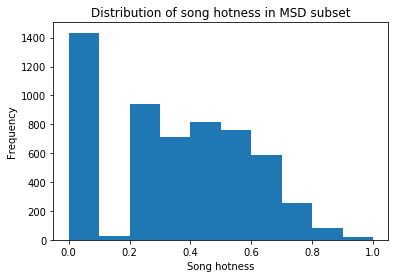

In [18]:
plt.hist(data.song_hotttnesss)
plt.title('Distribution of song hotness in MSD subset')
plt.xlabel('Song hotness')
plt.ylabel('Frequency');

In [19]:
# What percentage are zero?
print('Percentage of remaining records with zero song hotness values: {}%'.format(np.around((data['song_hotttnesss'] == 0).sum() / len(data)*100), 2))
      

Percentage of remaining records with zero song hotness values: 25.0%


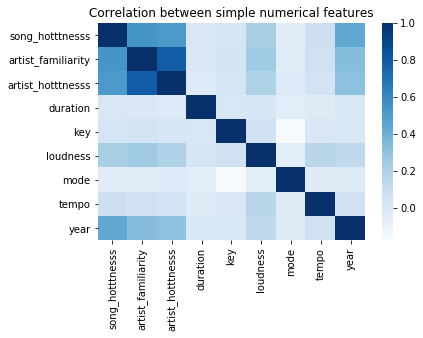

In [20]:
correlations = data.corr()
sns.heatmap(correlations, cmap = 'Blues')
plt.title('Correlation between simple numerical features');

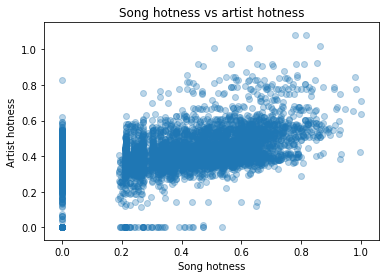

In [21]:
plt.scatter(data['song_hotttnesss'], data['artist_hotttnesss'], alpha = 0.3)
plt.title('Song hotness vs artist hotness')
plt.xlabel('Song hotness')
plt.ylabel('Artist hotness');

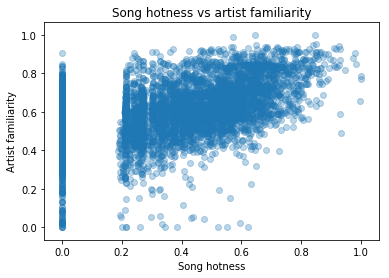

In [22]:
plt.scatter(data['song_hotttnesss'], data['artist_familiarity'], alpha = 0.3)
plt.title('Song hotness vs artist familiarity')
plt.xlabel('Song hotness')
plt.ylabel('Artist familiarity');

There is a slight positive trend of song hotness over time, which makes sense given the way that the metric is measured. We must also consider that musical tastes change over time. 

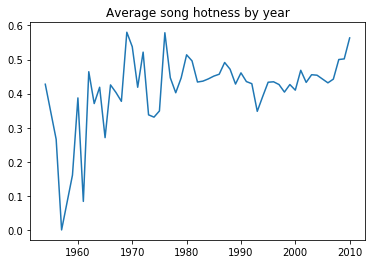

In [23]:
year_plot = data[data['year'] != 0].groupby(['year']).mean().reset_index()
plt.plot(year_plot['year'], year_plot['song_hotttnesss']);
plt.title('Average song hotness by year');

In [24]:
# Check number of years with value 0
print('Number of records with year recorded as zero: {}'.format(sum(data['year'] == 0)))

Number of records with year recorded as zero: 2584


# Merge with other datasets

The basic MSD dataset has some useful fields, but we have to explore whether we can augment this with other information. 

## Genre information

I had a look at whether we can augment the dataset with genre information. Although there is some genre information in the tags, this is mixed with other data like location and it isn't clear which is the main genre. Therefore I have linked with another dataset from Vienna University, available at: http://www.ifs.tuwien.ac.at/mir/msd/download.html


In [25]:
# Read genre info from the website
genres = pd.read_csv('http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls',
                       sep = '\t', 
                       header = None)

genres.columns=['track_id', 'genre_id']
genres.head()

,track_id,genre_id
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAV128F421A322,Pop_Rock
2,TRAAAAW128F429D538,Rap
3,TRAAABD128F429CF47,Pop_Rock
4,TRAAACV128F423E09E,Pop_Rock


In [26]:
# Read genre info from the website
styles = pd.read_csv('http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MASD-styleAssignment.cls',
                       sep = '\t', 
                       header = None)

styles.columns=['track_id', 'style']
styles.head()

,track_id,style
0,TRAAAAK128F9318786,Metal_Alternative
1,TRAAAAV128F421A322,Punk
2,TRAAAAW128F429D538,Hip_Hop_Rap
3,TRAAACV128F423E09E,Rock_Neo_Psychedelia
4,TRAAAEF128F4273421,Pop_Indie


In [27]:
#lets check whether track_id is unique in genre and style dataset
print(len(genres))
print((genres.track_id.nunique()))
print(len(styles))
print((styles.track_id.nunique()))

422714
422714
273936
273936


track_id is unique in both datasets however we will query how many tracks from genre and style match with main songs dataset

In [28]:
# Merge on track ID
subset_augmented = subset_full.merge(genres, 
                                     how = 'left',
                                     on = 'track_id')
subset_augmented = subset_augmented.merge(styles, 
                                     how = 'left',
                                     on = 'track_id')

In [29]:
# Boo... more than half are missing - we will have to see if there are other sources that might improve things
subset_augmented['genre_id'].isna().sum(), subset_augmented['style'].isna().sum() 


(5989, 7224)

In [30]:
subset_augmented.shape

(10000, 56)

## Rhythm Histogram data. 

Copy at https://drive.google.com/open?id=1dNTS0CL5zNy17fOjdusemsiPpnMSuWPp

In [31]:
# rh_data = pd.read_csv(cur_dir + '/../../data/msd-rh.csv.gz', header=None, compression='gzip', escapechar='\'')
rh_data = pd.read_csv(msd_subset_path + '/rythmhist/msd-rh.csv.gz', header=None, compression='gzip', escapechar='\'')



In [32]:
rh_data[60]=rh_data[60].str.replace(',','')

In [33]:
rh_data.shape

(994185, 61)

In [34]:
rh_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000,994185.000000
mean,10.747208,8.804710,7.545514,6.632828,6.130460,5.867655,5.436778,5.082182,5.028319,4.804715,4.618021,4.740827,4.748943,4.393691,4.123987,4.007699,3.873104,3.840052,3.802111,3.541086,3.396043,3.327304,3.236329,3.286237,3.394515,3.193727,3.020321,2.932759,2.786210,2.718177,2.688330,2.645896,2.566184,2.543914,2.508047,2.480911,2.461847,2.444112,2.327892,2.273370,2.198871,2.154295,2.106203,2.074629,2.028703,1.987840,2.001718,2.005123,2.019334,2.081961,2.033919,1.935411,1.858131,1.831933,1.807096,1.770416,1.726511,1.675519,1.657650,1.628000
std,4.745723,3.623742,2.990341,2.773978,2.634145,2.449711,2.267750,2.201609,2.311368,2.184540,2.078767,2.317916,2.554379,2.228124,2.005171,1.984086,1.998282,2.080600,2.131224,1.896828,1.773172,1.753022,1.738909,1.917375,2.334429,2.022861,1.778731,1.738296,1.561588,1.510218,1.483446,1.523024,1.447878,1.484905,1.462194,1.490071,1.487507,1.515765,1.371641,1.329778,1.212377,1.191753,1.148849,1.119682,1.068259,1.067603,1.109623,1.192496,1.327821,1.613612,1.532467,1.239517,1.108285,1.108109,1.113279,1.033209,0.968262,0.903420,0.856319,0.798481
min,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000222,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223
25%,7.434689,6.276521,5.462106,4.695081,4.304360,4.188430,3.869108,3.559366,3.461473,3.320068,3.200542,3.203318,3.127618,2.949085,2.804547,2.712347,2.593171,2.529792,2.472563,2.349306,2.271521,2.222684,2.152268,2.132991,2.095954,2.031689,1.972940,1.919386,1.850632,1.811181,1.791342,1.747137,1.710075,1.688737,1.660016,1.626730,1.606363,1.582164,1.533429,1.506323,1.477017,1.443220,1.418543,1.402386,1.377259,1.349058,1.346721,1.331677,1.318168,1.303640,1.279702,1.264551,1.240451,1.221177,1.199138,1.183471,1.163148,1.138751,1.129876,1.118636
50%,10.114451,8.432142,7.242066,6.364112,5.840643,5.617054,5.205885,4.847803,4.721892,4.527791,4.363730,4.386599,4.293448,4.031709,3.830349,3.704218,3.548375,3.468533,3.403843,3.216387,3.104187,3.035678,2.938959,2.920724,2.884994,2.783797,2.692683,2.611853,2.519052,2.460497,2.433397,2.375835,2.317170,2.283945,2.252322,2.210325,2.184457,2.156495,2.085823,2.047876,2.008082,1.967232,1.932481,1.908927,1.875202,1.836798,1.835027,1.819052,1.805077,1.792123,1.757127,1.737075,1.700535,1.676012,1.644394,1.623440,1.598302,1.562451,1.549573,1.531355
75%,13.363227,10.913700,9.300042,8.262290,7.607399,7.238793,6.734788,6.318180,6.207196,5.941693,5.721525,5.829992,5.772175,5.368905,5.071119,4.915226,4.722922,4.654492,4.593721,4.298268,4.132630,4.040328,3.914323,3.927644,3.931337,3.759103,3.599590,3.482811,3.

In [35]:
rh_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,7.224382,6.109045,6.685568,4.966105,7.842882,2.844719,3.361026,3.442607,2.590563,2.510110,3.489836,2.620875,2.981837,2.658234,1.991701,2.865213,2.446870,2.362090,2.119853,3.402324,3.312368,5.171416,4.306777,2.578843,2.354629,2.439796,2.315009,2.478483,1.720365,1.946930,2.176049,2.151473,1.484158,2.463190,1.587826,1.725714,1.896247,2.057304,1.676314,1.668819,2.377014,2.578647,2.352990,2.619982,7.261864,3.851958,2.034727,1.937198,2.327277,1.400687,1.881342,1.644958,1.651929,1.744542,1.560066,1.471327,1.278020,1.450461,1.744244,1.308790,TRUNNPU128F42509AF
1,14.677012,11.396501,6.471495,6.448495,5.532688,5.459681,4.962178,6.169852,4.361400,4.689114,5.028985,3.808006,3.670783,4.345497,3.470329,3.411302,3.164273,3.066168,2.413340,2.574592,3.005441,2.862182,2.974478,2.755254,2.206445,3.645482,2.236688,3.027635,1.394029,1.890757,1.722798,1.887297,1.530212,1.747953,1.625365,1.359184,1.404816,1.890264,1.235513,1.915746,1.394843,1.474570,1.152636,1.045539,1.150380,1.287604,1.181704,1.323699,1.039293,1.022161,1.062748,1.169235,1.154576,1.056674,0.885865,1.031910,1.069888,0.799239,0.932625,0.920351,TRHOCGC128F4289D7E
2,4.693787,8.161283,4.093479,3.973085,2.508202,2.896735,3.671773,3.639837,2.537774,2.026490,3.067868,2.307508,2.197447,1.665187,6.908271,1.751675,1.326321,1.868806,3.519019,3.226108,2.620849,2.199655,2.716995,1.371609,1.223698,1.662284,2.132717,2.728259,1.563425,10.511957,1.622031,1.747682,1.566627,1.682926,1.433441,1.676330,2.582308,2.296095,1.263071,2.048495,2.075836,1.391475,1.282799,1.161428,5.115295,1.494706,1.646880,1.675094,2.403007,1.378582,2.226650,1.726906,2.274374,1.447875,1.258306,2.076403,1.436256,1.768820,1.088751,5.942637,TRUCDEN128F422F002
3,5.732590,4.595852,4.447026,3.445079,4.157514,3.177737,2.750734,2.316945,2.617048,4.041836,2.595810,2.025904,2.128921,1.868697,1.952426,1.938566,1.718140,1.925044,1.865080,1.869095,1.321608,1.114444,1.108346,1.160560,1.051970,1.033919,1.101187,1.131778,0.973218,1.187626,1.123574,1.042106,0.910357,0.838702,0.685756,0.794708,0.728102,0.646424,1.001201,0.841439,0.633582,0.625806,0.611139,0.695433,0.613495,0.601609,0.581338,0.566299,0.587599,0.512447,0.428625,0.545786,0.512769,0.497109,0.428288,0.464276,0.434104,0.469024,0.454484,0.373569,TRIRBZT128F4248E8E
4,6.782964,4.592204,4.587584,4.003001,2.943357,2.935050,2.497146,2.544335,2.608646,2.228174,2.053194,1.925623,1.829839,2.356808,2.334097,1.979131,2.007416,1.722231,1.474112,1.762297,1.552419,1.745466,3.290660,1.363205,1.413405,1.346467,1.226538,1.289772,1.691532,1.255177,1.459558,1.268531,1.188750,1.616032,1.097459,0.902051,1.417650,1.069397,1.103072,1.104875,1.048233,0.985500,1.136311,0.849429,0.992081,1.692612,1.002904,0.721470,1.133159,0.881244,1.429873,0.927437,1.044928,0.883083,0.772829,0.828493,0.946112,0.790503,0.777186,0.999154,TRURGGS12903CC654D


In [36]:
rh_data = rh_data.add_prefix('rythm_')
rh_data.rename(columns = {'rythm_60': 'track_id'}, inplace = True)

In [37]:
#lets check if track_id is unique in this data
print(len(rh_data))
print((rh_data.track_id.nunique()))

994185
994175


track_id is not unique and hence we will delete duplicate track_ids from the data before using it to join with our main datset

In [38]:
rh_data = rh_data.drop_duplicates(subset='track_id', keep='first')

In [39]:
#lets check if track_id is unique in this data
print(len(rh_data))
print((rh_data.track_id.nunique()))

994175
994175


In [40]:
subset_augmented = subset_augmented.merge(rh_data, 
                                     how = 'left',
                                     on = 'track_id')

In [41]:
# Check length of the merged data - looks quite complete
subset_augmented.shape

(10000, 116)

In [42]:
subset_augmented.head()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_mbtags,artist_mbtags_count,artist_name,artist_playmeid,artist_terms,artist_terms_freq,artist_terms_weight,audio_md5,bars_confidence,bars_start,beats_confidence,beats_start,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,release,release_7digitalid,sections_confidence,sections_start,segments_confidence,segments_loudness_max,segments_loudness_max_time,segments_loudness_start,segments_pitches,segments_start,segments_timbre,similar_artists,song_hotttnesss,song_id,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,title,track_7digitalid,track_id,year,genre_id,style,rythm_0,rythm_1,rythm_2,rythm_3,rythm_4,rythm_5,rythm_6,rythm_7,rythm_8,rythm_9,rythm_10,rythm_11,rythm_12,rythm_13,rythm_14,rythm_15,rythm_16,rythm_17,rythm_18,rythm_19,rythm_20,rythm_21,rythm_22,rythm_23,rythm_24,rythm_25,rythm_26,rythm_27,rythm_28,rythm_29,rythm_30,rythm_31,rythm_32,rythm_33,rythm_34,rythm_35,rythm_36,rythm_37,rythm_38,rythm_39,rythm_40,rythm_41,rythm_42,rythm_43,rythm_44,rythm_45,rythm_46,rythm_47,rythm_48,rythm_49,rythm_50,rythm_51,rythm_52,rythm_53,rythm_54,rythm_55,rythm_56,rythm_57,rythm_58,rythm_59
0,22050.0,165270.0,0.581794,0.401998,ARD7TVE1187B99BFB1,NaN,California - LA,NaN,e77e51a5-4761-45b3-9847-2051f811e366,[],[],Casual,4479.0,"[hip hop, underground rap, g funk, alternative...","[1.0, 0.7761362332679642, 0.7296697949672141, ...","[1.0, 0.8979359555142553, 0.8842618474718359, ...",a222795e07cd65b7a530f1346f520649,"[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...",0.0,218.93179,0.247,0.0,1.0,0.736,-11.197,0.0,0.636,Fear Itself,300848.0,"[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.0, 7.74554, 36.44331, 43.61667, 75.17954, 9...","[0.0, 1.0, 0.483, 0.137, 0.42, 1.0, 0.257, 1.0...","[-60.0, -31.646, -34.565, -38.407, -34.696, -2...","[0.0, 0.10929, 0.11044, 0.0844, 0.05898, 0.073...","[-60.0, -60.0, -40.84, -40.401, -38.456, -39.6...","[[0.946, 0.684, 0.679, 0.941, 0.744, 0.633, 0....","[0.0, 0.24671, 0.47116, 0.80376, 0.89551, 1.12...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[b'ARV4KO21187FB38008', b'ARWHM281187FB3D381',...",0.602120,SOMZWCG12A8C13C480,218.932,"[0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...","[0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...",92.198,4.0,0.778,I Didn't Mean To,3401791.0,TRAAAAW128F429D538,0.0,Rap,Hip_Hop_Rap,11.529769,11.889242,6.971235,10.061335,10.500120,6.455155,6.931427,5.215461,12.913949,6.321778,5.076225,5.045199,4.971353,8.073747,4.650728,6.364284,4.892973,12.757817,6.240585,4.513851,4.029875,3.645704,7.330062,3.314496,3.340606,2.627752,4.364200,3.365758,2.757400,3.373692,2.594304,5.191587,2.335049,3.837536,3.374418,4.423642,5.027046,2.280069,3.291304,2.367638,4.343383,2.047874,2.383144,2.907563,2.147879,3.145177,2.231606,2.489490,2.115169,3.154752,2.019161,1.896583,2.018051,2.292442,3.801891,1.945810,2.444633,1.801797,2.781403,2.472900
1,22050.0,1998.0,0.630630,0.417500,ARMJAGH1187FB546F3,35.14968,"Memphis, TN",-90.04892,1c78ab62-db33-4433-8d0b-7c8dcf1849c2,[b'classic pop and rock'],[1],The Box Tops,22066.0,"[blue-eyed soul, pop rock, blues-rock, beach m...","[1.0, 0.8931999928346939, 0.7860602885494408, ...","[1.0, 0.8459884034332037, 0.8306895698215381, ...",bb9771eeef3d5b204a3c55e690f52a91,"[0.007, 0.259, 0.172, 0.404, 0.011, 0.016, 0.0...","[0.71054, 2.71502, 4.70861, 6.69288, 8.66941, ...","[1.0, 0.945, 0.714, 0.973, 0.818, 0.974, 0.878...","[0.20627, 0.71054, 1.21836, 1.71841, 2.21729, ...",0.0,148.03546,0.148,0.0,6.0,0.169,-9.843,0.0,0.430,Dimensions,300822.0,"[1.0, 0.451, 0.27, 0.397, 0.225, 0.426, 0.459,...","[0.0, 8.1777, 19.52952, 38.84063, 50.22563, 70...","[0.0, 1.0, 0.93

In [43]:
subset_augmented.describe()

,analysis_sample_rate,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_latitude,artist_longitude,artist_playmeid,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,mode_confidence,release_7digitalid,song_hotttnesss,start_of_fade_out,tempo,time_signature,time_signature_confidence,track_7digitalid,year,rythm_0,rythm_1,rythm_2,rythm_3,rythm_4,rythm_5,rythm_6,rythm_7,rythm_8,rythm_9,rythm_10,rythm_11,rythm_12,rythm_13,rythm_14,rythm_15,rythm_16,rythm_17,rythm_18,rythm_19,rythm_20,rythm_21,rythm_22,rythm_23,rythm_24,rythm_25,rythm_26,rythm_27,rythm_28,rythm_29,rythm_30,rythm_31,rythm_32,rythm_33,rythm_34,rythm_35,rythm_36,rythm_37,rythm_38,rythm_39,rythm_40,rythm_41,rythm_42,rythm_43,rythm_44,rythm_45,rythm_46,rythm_47,rythm_48,rythm_49,rythm_50,rythm_51,rythm_52,rythm_53,rythm_54,rythm_55,rythm_56,rythm_57,rythm_58,rythm_59
count,10000.0,10000.000000,9996.000000,10000.000000,3742.000000,3742.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5648.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000,9959.000000
mean,22050.0,109541.695500,0.565456,0.385552,37.157357,-63.933358,25547.117000,0.0,238.507518,0.758616,0.0,5.276100,0.449573,-10.485668,0.691100,0.477784,371033.508000,0.342822,229.975465,122.915449,3.564800,0.509937,4.122549e+06,934.704600,11.102293,9.138143,7.788747,6.927674,6.375210,5.967738,5.555127,5.269904,5.206700,4.949334,4.734413,4.806144,4.731166,4.461099,4.266219,4.128749,3.994087,3.939401,3.870150,3.642907,3.493586,3.393609,3.306927,3.354696,3.350978,3.217528,3.042290,2.947742,2.828847,2.805588,2.739959,2.703775,2.627374,2.588210,2.558877,2.548264,2.489893,2.470808,2.389394,2.331018,2.248056,2.181854,2.128293,2.092365,2.059537,2.019592,2.023212,2.012789,2.001588,2.010105,1.996537,1.930678,1.853111,1.814253,1.797089,1.756296,1.714255,1.677892,1.672862,1.645289
std,0.0,142079.791611,0.160161,0.143647,15.598494,50.508223,44001.390646,0.0,114.137514,1.867952,0.0,3.554087,0.274974,5.399788,0.462063,0.191254,236764.904751,0.247220,112.195735,35.184412,1.266239,0.373409,2.628539e+06,996.650657,4.744968,3.634858,3.047357,2.840757,2.721605,2.439794,2.312647,2.314331,2.433176,2.279470,2.122346,2.314524,2.460346,2.249354,2.161695,2.143035,2.128541,2.182455,2.153070,1.966046,1.878777,1.780316,1.768619,1.996570,2.149255,2.014467,1.759527,1.674914,1.570977,1.662069,1.589536,1.634278,1.571233,1.521140,1.494154,1.613301,1.540085,1.568222,1.473355,1.436710,1.320069,1.187153,1.157770,1.153038,1.111525,1.110481,1.143099,1.194305,1.258810,1.340993,1.432896,1.221596,1.060363,1.005440,1.040978,0.970846,0.897671,0.867261,0.858549,0.833241
min,22050.0,-1.000000,0.000000,0.000000,-41.280540,-162.436500,-1.000000,0.0,1.044440,0.000000,0.0,0.000000,0.000000,-51.643000,0.000000,0.000000,63.000000,0.000000,1.044000,0.000000,0.000000,0.000000,8.450000e+02,0.000000,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,

lets analyse string features to be used for machine learning model that predicts song hotness

In [44]:
#renaming column call 'style' as its a reserved keyword in python
subset_augmented.rename(columns = {'style': 'style_id'}, inplace = True)

In [45]:
print('number of total fields are: ' + str(subset_augmented.shape[1]))
print('number of numeric fields are: ' + str(subset_augmented._get_numeric_data().shape[1]))
print('number of unique genres are: ' + str(subset_augmented.genre_id.nunique()))
print('number of unique style are: ' + str(subset_augmented.style_id.nunique()))
print('number of unique artist locations are: ' + str(subset_augmented.artist_location.nunique()))

number of total fields are: 116
number of numeric fields are: 84
number of unique genres are: 21
number of unique style are: 25
number of unique artist locations are: 1046


From above, we can use all numeric features, onehot encoded features for genre and style. We will exclude other features such as array based features, strings having too many categories to build a model. As we noticed earlier when we performed EDA, we will drop rows with missing song hotness, we will also drop columns such as danceability and energy and id columns that make little sense.

We will also scale the numeric columns and create one hot encoded features for string columns

In [571]:
from sklearn.preprocessing import MinMaxScaler


print('Total columns in augmented data: ' + str(subset_augmented.shape[1]))

#dropping rows with missing song hotness
data = subset_augmented.dropna(subset = ['song_hotttnesss'])
print('Shape of dataframe after removing missing song hotness: ' + str(data.shape))


#selecting numeric columns
data_num = data._get_numeric_data()
print('Shape of dataframe after selecting numeric columns: ' + str(data_num.shape))


#dropping danceability and energy and digital id 
cols_to_drop = ['danceability', 'energy', 'release_7digitalid', 'track_7digitalid','artist_7digitalid','artist_playmeid']
data_num = data_num.drop(columns = cols_to_drop)
print('Shape of dataframe after deleting ids and other useless numeric columns: ' + str(data_num.shape))

#assigning song hotness to a target while dropping it from featureset
song_hotness = data_num[['song_hotttnesss']]
data_num = data_num.drop(columns = 'song_hotttnesss')                               
          
                
#scaling numeric columns
scaler = MinMaxScaler() 
data_num_scaled = pd.DataFrame(scaler.fit_transform(data_num.values),columns = data_num.columns)


#adding useful string columns genre and style and add one hot encoded features for the same

cols_to_encode = ['genre_id', 'style_id']
string_encoded_features = pd.get_dummies(data[cols_to_encode], prefix=['genre', 'style']).reset_index(drop = True)
featureset = pd.concat([data_num_scaled, string_encoded_features],axis = 1)


print('Shape of dataframe after adding encoded features for string columns: ' + str(featureset.shape))

print('Shape of featureset: ' + str(featureset.shape) + ' and shape of target: '+ str(song_hotness.shape))


Total columns in augmented data: 116
Shape of dataframe after removing missing song hotness: (5648, 116)
Shape of dataframe after selecting numeric columns: (5648, 84)
Shape of dataframe after deleting ids and other useless numeric columns: (5648, 78)
Shape of dataframe after adding encoded features for string columns: (5648, 123)
Shape of featureset: (5648, 123) and shape of target: (5648, 1)


In [572]:
featureset.head()

,analysis_sample_rate,artist_familiarity,artist_hotttnesss,artist_latitude,artist_longitude,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tempo,time_signature,time_signature_confidence,year,rythm_0,rythm_1,rythm_2,rythm_3,rythm_4,rythm_5,rythm_6,rythm_7,rythm_8,rythm_9,rythm_10,rythm_11,rythm_12,rythm_13,rythm_14,rythm_15,rythm_16,rythm_17,rythm_18,rythm_19,rythm_20,rythm_21,rythm_22,rythm_23,rythm_24,rythm_25,rythm_26,rythm_27,rythm_28,rythm_29,rythm_30,rythm_31,rythm_32,rythm_33,rythm_34,rythm_35,rythm_36,rythm_37,rythm_38,rythm_39,rythm_40,rythm_41,rythm_42,rythm_43,rythm_44,rythm_45,rythm_46,rythm_47,rythm_48,rythm_49,rythm_50,rythm_51,rythm_52,rythm_53,rythm_54,rythm_55,rythm_56,rythm_57,rythm_58,rythm_59,genre_Avant_Garde,genre_Blues,genre_Children,genre_Classical,genre_Comedy_Spoken,genre_Country,genre_Easy_Listening,genre_Electronic,genre_Folk,genre_Holiday,genre_International,genre_Jazz,genre_Latin,genre_New Age,genre_Pop_Rock,genre_Rap,genre_Reggae,genre_Religious,genre_RnB,genre_Stage,genre_Vocal,style_Big_Band,style_Blues_Contemporary,style_Country_Traditional,style_Dance,style_Electronica,style_Experimental,style_Folk_International,style_Gospel,style_Grunge_Emo,style_Hip_Hop_Rap,style_Jazz_Classic,style_Metal_Alternative,style_Metal_Death,style_Metal_Heavy,style_Pop_Contemporary,style_Pop_Indie,style_Pop_Latin,style_Punk,style_Reggae,style_RnB_Soul,style_Rock_Alternative,style_Rock_College,style_Rock_Contemporary,style_Rock_Hard,style_Rock_Neo_Psychedelia
0,0.0,0.581794,0.371359,NaN,NaN,0.117141,0.007491,0.090909,0.736,0.721632,0.0,0.636,0.118340,0.350792,0.571429,0.778,0.000000,0.298795,0.456692,0.284249,0.427630,0.376937,0.289970,0.237904,0.255454,0.491393,0.288667,0.255605,0.172307,0.221531,0.266684,0.229308,0.279883,0.231347,0.540199,0.311324,0.218832,0.197490,0.162825,0.362209,0.132077,0.128335,0.118196,0.223633,0.165694,0.141793,0.130440,0.105549,0.293562,0.074898,0.196591,0.183865,0.213457,0.248015,0.111045,0.146759,0.103250,0.231424,0.158554,0.147580,0.169419,0.179535,0.185465,0.124320,0.100950,0.081158,0.133291,0.118714,0.124098,0.111305,0.174071,0.246850,0.154016,0.165901,0.155324,0.216564,0.165079,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0.651046,0.371106,NaN,NaN,0.111983,0.002002,0.181818,0.092,0.880091,1.0,0.371,0.107035,0.493623,0.571429,0.562,0.998507,0.160256,0.280109,0.313741,0.209657,0.171977,0.238748,0.167460,0.176080,0.172987,0.243897,0.194131,0.139713,0.254590,0.124049,0.186235,0.229766,0.139805,0.151082,0.257411,0.139693,0.167770,0.162355,0.145643,0.117439,0.120290,0.222629,0.142190,0.125427,0.150403,0.088322,0.088526,0.187218,0.070978,0.104424,0.178743,0.090963,0.103317,0.132081,0.107658,0.095694,0.100541,0.154826,0.106822,0.095777,0.236510,0.099363,0.105727,0.095565,0.078429,0.073595,0.252009,0.181600,0.119257,0.135592,0.104883,0.132776,0.097235,0.186145,0.129077,0.116586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.0,0.426668,0.306951,NaN,NaN,0.145284,0.160742,0.363636,0.717,0.667227,1.0,0.652,0.140722,0.329657,0.571429,0.487,0.987065,0.221622,0.378348,0.228346,0.296391,0.181957,0.241260,0.162161,0.301842,0.152437,0.168557,0.198256,0.116449,0.170760,0.088148,0.139434,0.096489,0.180687,0.116389,0.147919,0.141098,0.162578,0.148724,0.124816,0.108833,0.104500,0.130431,0.132738,0.154564,0.124900,0.108612,0.084130,0.173537,0.075128,0.169932,0.157852,0.111917,0.096845,0.096361,0.092915,0.082597,0.112811,0.143386,0.122948,0.103515,0.172364,0.089609,0.085985,0.059206,0.060502,0.063707,0.117874,0.129421,0.114500,0.146718,0.104332,0.138029,0.135881,0.181948,0.135454,0.120199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0.0,0.360031,0.273689,0.689616,0.244413,0.117054,0.064449,0.454545,0.354,0.749462,0.0,0.485,0.111680,0.558407,0.142857,0.000,0.000000,0.260802,0.282786,0.186389,0.182786,0.138273,0.14787

Text(0.5, 0, 'song_hotness')

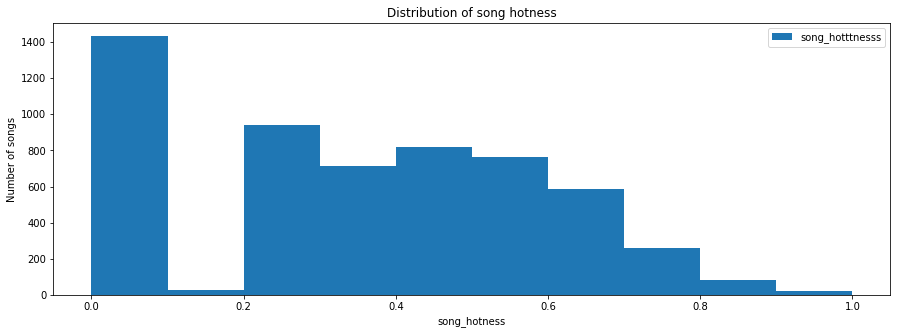

In [573]:
#lets look at the distribution of hotness to categorise hot songs
song_hotness.plot(kind='hist', y='song_hotttnesss', figsize=(15, 5), title='Distribution of song hotness')
plt.ylabel("Number of songs")
plt.xlabel("song_hotness")

In [574]:
song_hotness['song_hotttnesss'].describe()

count    5648.000000
mean        0.342822
std         0.247220
min         0.000000
25%         0.000000
50%         0.360371
75%         0.537504
max         1.000000
Name: song_hotttnesss, dtype: float64

In [575]:
#Assigning top 25% songs with respect to song hotness as a hot song
song_hotness['song_hotttnesss'] = song_hotness['song_hotttnesss']>=0.537504


Lets scale the numeric columns add create one hot encoded features for string columns

In [576]:
song_hotness.song_hotttnesss.value_counts()

False    4239
True     1409
Name: song_hotttnesss, dtype: int64

As seen above, total 1409 songs are classified as hot songs

## Lets build our first model that predicts song hotness.

### Classical models

In [577]:
#lets replace all NAs in feature set with 0 
featureset.fillna(0, inplace= True)

In [578]:
#split data into train and test

ratio = 0.7

nrow = np.random.rand(len(featureset)) <= 0.7

X_train = featureset[nrow]
X_test = featureset[~nrow]
y_train = song_hotness[nrow].values.ravel()
y_test = song_hotness[~nrow].values.ravel()

In [579]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

### Fitting various classical models and plotting their accuracy metrics

Accuracy and AUC (test) for Logistic: 82.0% and 0.76 respectively 
Accuracy and AUC (test) for Naive Bayes: 35.5% and 0.59 respectively 
Accuracy and AUC (test) for Support Vector Classification: 82.1% and 0.76 respectively 
Accuracy and AUC (test) for Random Forest: 82.0% and 0.77 respectively 


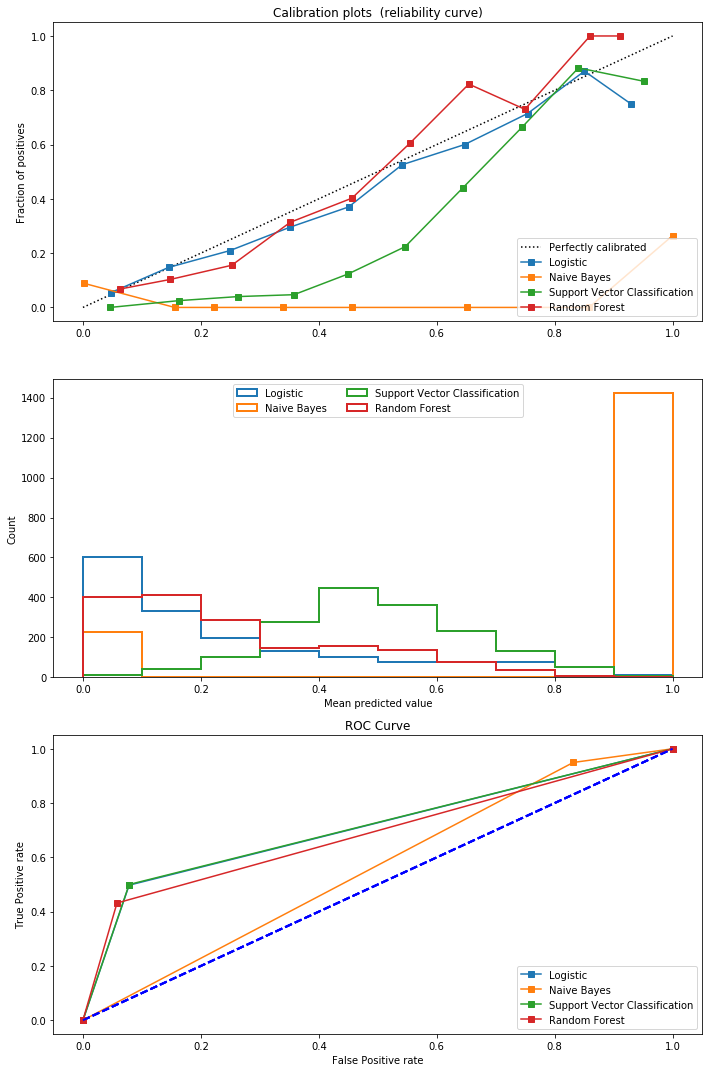

In [580]:
import warnings
warnings.filterwarnings('ignore')
# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,figsize=(10, 15))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
        
    # computing accuracy    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    #computing auc
    auc = roc_auc_score(y_pred,y_test)
    print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))
    
    #computing fpr and tpr
    fpr, tpr,_= roc_curve(y_test,y_pred,drop_intermediate=False)
       

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
    
    ax3.plot(fpr, tpr, "s-", label="%s" % (name, ))
    ax3.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


ax3.set_xlabel("False Positive rate")
ax3.set_ylabel("True Positive rate")
ax3.set_ylim([-0.05, 1.05])
ax3.legend(loc="lower right")
ax3.set_title('ROC Curve')

plt.tight_layout()
plt.show()


    

### Random forest seems to be doing good with around 80% accuracy with area under the curve = .77

In [581]:
#lets fit a random forest model and then find features that are important to predict song hotness

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

# computing accuracy    
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

#computing auc
auc = roc_auc_score(y_pred,y_test)
print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))


Accuracy and AUC (test) for Random Forest: 82.0% and 0.77 respectively 


Text(0.5, 0, 'Relative Importance')

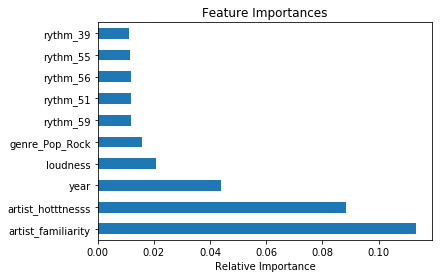

In [584]:
feat_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

### Artist familiarity, hotness, year, song loudness, genre being pop and rock, and some rythm variables tend to be important features in predicting song hotness

### lets fit a multilayer perceptron to see if it performs better

In [387]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier


Using TensorFlow backend.


In [438]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from sklearn.metrics import roc_auc_score, confusion_matrix

In [476]:
# Set random seed for reproducibility
seed = 7
np.random.seed(seed)

# Create a baseline model, to see what results we may get

#function for auc


def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


def create_baseline():
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',auroc])
    return model




In [477]:
epochs = 50
batch_size = 64

In [478]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch_size, verbose=0)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("A mean of %.2f%%  with a standard deviation of %.2f%%" % (results.mean()*100, results.std()*100))

A mean of 76.40%  with a standard deviation of 0.99%


In [483]:
# Fit the model
lr_model_history  =estimator.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 0) 
y_pred = estimator.predict(X_test)

In [486]:
print('test data accuracy is ' + str(accuracy_score(y_pred,y_test)) + ' and auc is ' + str(roc_auc_score(y_pred,y_test)))

test data accuracy is 0.7387755102040816 and auc is 0.6658123585972852


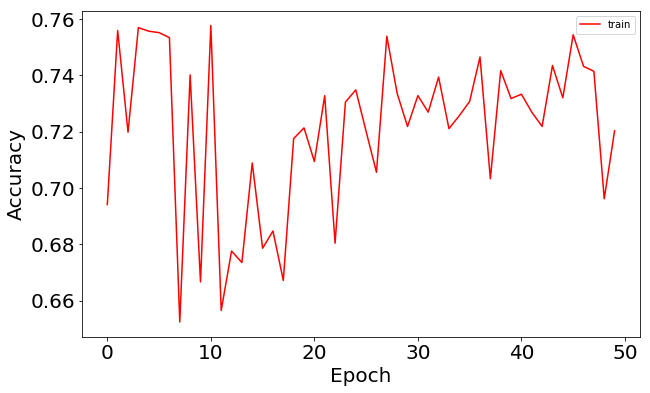

In [487]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot((lr_model_history.history['acc']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

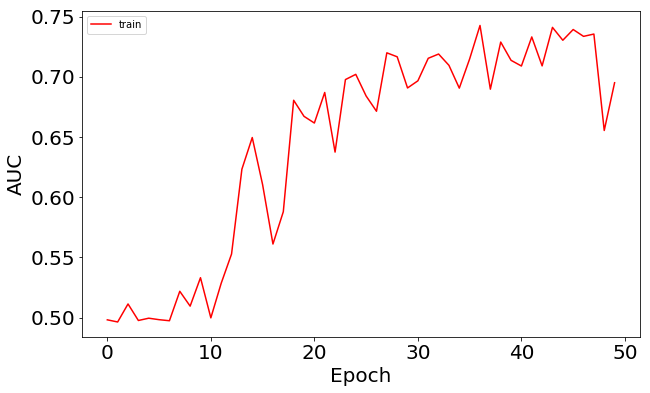

In [488]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot((lr_model_history.history['auroc']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'AUC', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

### MLP provides similar results as RandomForest but RandomForest is still doing better

# Lets load lyrics data

### Download data from this path and place database in your local data folder

http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_dataset.db

In [55]:
#parsing the sql database for the lyrics data
import sqlite3
con = sqlite3.connect(msd_subset_path+ '/musixmatch/mxm_dataset.db')
words = pd.read_sql(sql = 'SELECT * FROM words', con = con)
lyrics_0 = pd.read_sql(sql = 'SELECT * FROM lyrics', con = con)
con.close()


In [56]:
print('shape of words is: ' + str(words.shape))
print('shape of lyrics is: ' + str(lyrics_0.shape))

shape of words is: (5000, 1)
shape of lyrics is: (19045332, 5)


In [57]:
lyrics_0.head()

,track_id,mxm_tid,word,count,is_test
0,TRAAAAV128F421A322,4623710,i,6,0
1,TRAAAAV128F421A322,4623710,the,4,0
2,TRAAAAV128F421A322,4623710,you,2,0
3,TRAAAAV128F421A322,4623710,to,2,0
4,TRAAAAV128F421A322,4623710,and,5,0


In [58]:
#lets check how many songs are captured in lyrics data from main subset
lyrics_1 = pd.merge(subset_augmented, lyrics_0[['track_id']] , on = 'track_id', how = 'inner')
lyrics_1.track_id.nunique()

2350

### Only 2350 songs have lyrics data from 10,000 songs subset of MSD

In [59]:
#lets check the distribution of song hotness for the tracks available in lyrics data
song_hotness_lyrics = lyrics_1[['track_id','song_hotttnesss']].drop_duplicates()

Text(0.5, 0, 'song_hotness')

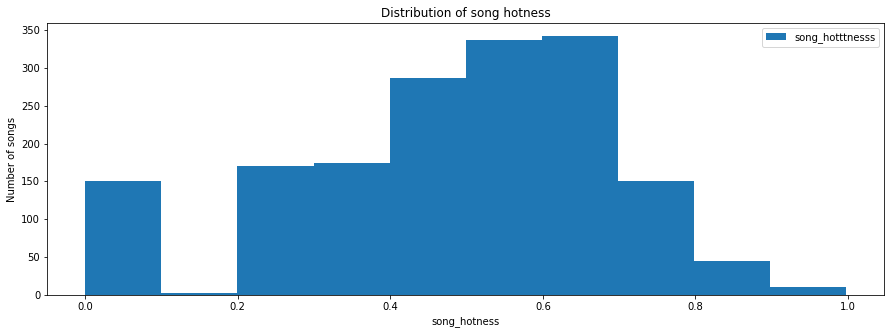

In [60]:
song_hotness_lyrics.plot(kind='hist', y='song_hotttnesss', figsize=(15, 5), title='Distribution of song hotness')
plt.ylabel("Number of songs")
plt.xlabel("song_hotness")

In [61]:
# number of songs for which song hotness is null from 2,350 songs
song_hotness_lyrics.song_hotttnesss.isna().sum()

682

In [85]:
from string import punctuation
import nltk
nltk.download('stopwords')
stop = stopwords.words('english') +list(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rgupta25\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
len(stop)

211

In [82]:
#finding small words in lyrics data
small_words = [i for i in words.word if len(i)<=2]
len(small_words)

244

In [87]:
#adding small words in stop words
stop = stop + list(small_words)
len(stop)

455

In [132]:
#Dropping stop words and very short words from lyrics data
lyrics_1 = lyrics_0[~lyrics_0.word.isin(stop)]
lyrics_1

,track_id,mxm_tid,word,count,is_test
22,TRAAAAV128F421A322,4623710,like,2,0
27,TRAAAAV128F421A322,4623710,got,1,0
28,TRAAAAV128F421A322,4623710,would,1,0
31,TRAAAAV128F421A322,4623710,seem,1,0
32,TRAAAAV128F421A322,4623710,someon,1,0
33,TRAAAAV128F421A322,4623710,understand,1,0
34,TRAAAAV128F421A322,4623710,pass,1,0
35,TRAAAAV128F421A322,4623710,river,1,0
36,TRAAAAV128F421A322,4623710,met,1,0
37,TRAAAAV128F421A322,4623710,piec,1,0


In [133]:
print(lyrics_1.word.unique())

['like' 'got' 'would' ... 'pudiera' 'vuela' 'bla']


In [134]:
lyrics_1.word.nunique()

4674

### the words in lyrics data are stemmed versions of the original words. We can replace them with the original words to make better sense. The data for unstemmed words can be downloaded from http://labrosa.ee.columbia.edu/millionsong/sites/default/files/mxm_reverse_mapping.txt

In [135]:
#Replacing the tokens with unstemmed versions for better comprehension
unstem = pd.read_csv(msd_subset_path + '/musixmatch/mxm_reverse_mapping.txt', sep = '<SEP>', names = ['original','unstemmed'])

In [136]:
len(unstem)

5000

In [137]:
unstem.head(10)

,original,unstemmed
0,dÃ­a,dÃ­a
1,pido,pido
2,hatr,hatred
3,pide,pide
4,yellow,yellow
5,four,four
6,sleev,sleeve
7,sleep,sleep
8,thirst,thirst
9,upsid,upside


In [138]:
unstem.columns = ['word', 'unstemmed_word']

In [139]:
unstem.head(10)

,word,unstemmed_word
0,dÃ­a,dÃ­a
1,pido,pido
2,hatr,hatred
3,pide,pide
4,yellow,yellow
5,four,four
6,sleev,sleeve
7,sleep,sleep
8,thirst,thirst
9,upsid,upside


In [140]:
#merging stemmed words in lyrics data with their unstemmed versions
lyrics_2 = pd.merge(lyrics_1, unstem, on = 'word', how = 'left')

In [141]:
lyrics_2.head()

,track_id,mxm_tid,word,count,is_test,unstemmed_word
0,TRAAAAV128F421A322,4623710,like,2,0,like
1,TRAAAAV128F421A322,4623710,got,1,0,got
2,TRAAAAV128F421A322,4623710,would,1,0,would
3,TRAAAAV128F421A322,4623710,seem,1,0,seems
4,TRAAAAV128F421A322,4623710,someon,1,0,someone


In [142]:
#dropping word column and rename unstemmed_word with word
lyrics_2.drop('word', axis = 1, inplace = True)
lyrics_2.rename(columns={'unstemmed_word':'word'}, inplace=True)
lyrics_2.head()

,track_id,mxm_tid,count,is_test,word
0,TRAAAAV128F421A322,4623710,2,0,like
1,TRAAAAV128F421A322,4623710,1,0,got
2,TRAAAAV128F421A322,4623710,1,0,would
3,TRAAAAV128F421A322,4623710,1,0,seems
4,TRAAAAV128F421A322,4623710,1,0,someone


In [231]:
#total tracks in lyrics data
print('total tracks in lyrics data are: ' + str(lyrics_2.track_id.nunique()))

#using those tracks from lyrics data that are in subset

lyrics_2_sub = pd.merge(subset_augmented[['track_id']], lyrics_2 , on = 'track_id', how = 'inner')
print('total tracks from lyrics data in subset are: ' + str( lyrics_2_sub.track_id.nunique()))                                        
                                         

total tracks in lyrics data are: 237490
total tracks from lyrics data in subset are: 2349


In [232]:
#removing nans from lyrics data
lyrics_2_sub.shape

(129782, 5)

In [236]:
lyrics_2_sub = lyrics_2_sub[~lyrics_2_sub.word.isna()]

In [341]:
#Getting rid of columns I don't need
lyrics_3 = lyrics_2_sub[['track_id','word','count']]

#Converting the melted dataframe into a pivot table that will serve as my vectorized dataset
lyrics = pd.pivot_table(lyrics_3[['track_id','word','count']], values = 'count', index = 'track_id', columns = ['word'])

In [342]:
lyrics.shape

(2349, 4416)

In [343]:
#Filling in 0s
lyrics = lyrics.replace(to_replace=np.NaN, value = 0)


### Setting up LDA to find important topics

In [344]:
#Setting up the format to use the gensim modeling library
lyrics_text = [lyrics.columns[lyrics.loc[index,:].nonzero()] for index in lyrics.index]
dictionary = Dictionary(lyrics_text)
corpus_plot = [dictionary.doc2bow(text) for text in lyrics_text]

In [198]:
#Function to run an LDA and do a coherance model on it to find the best value of number of topics
from gensim.models.coherencemodel import CoherenceModel

def coherence_search(dictionary, corpus_dict, text, upper_limit, start, step):
    coherence_score = []
    model_list = []
    for num_topics in range(start, upper_limit, step):
        fun_model=models.ldamulticore.LdaMulticore(corpus=corpus_dict, 
                           id2word=dictionary, 
                           num_topics=num_topics,
                           passes = 5,
                           minimum_probability = 0.01)
        model_list.append(fun_model)
        coherencem = CoherenceModel(model=fun_model, texts=text, dictionary=dictionary, coherence='c_v', processes = 15)
        coherence_score.append(coherencem.get_coherence())

    return model_list, coherence_score

**Running the function and getting our LDA**

In [186]:
#Runnin function above for lyrics set
%timeit
search = coherence_search(dictionary=dictionary,corpus_dict=corpus_plot,text = lyrics_text, upper_limit= 100, start = 5, step = 5)

### Plotting Coherance to find best number of topics to cluster over

In [199]:
model_result = search[0]
scores = search[1]

Text(0, 0.5, 'coherence score')

<Figure size 864x720 with 0 Axes>

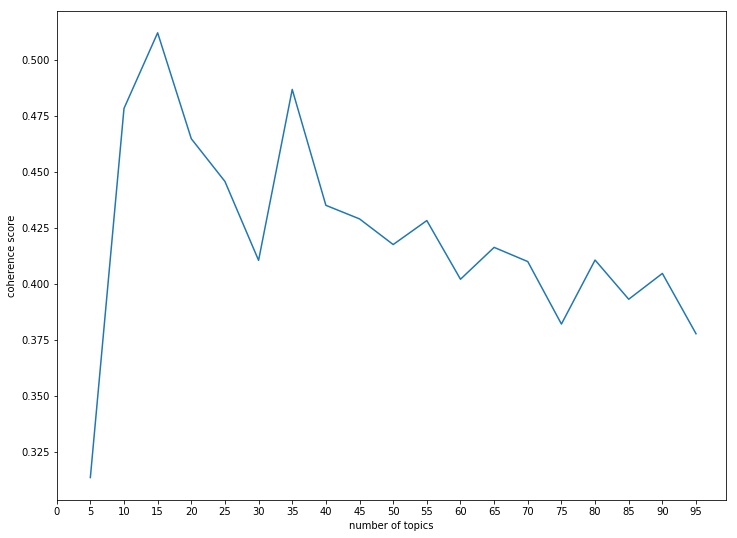

In [205]:
fig = plt.figure(figsize=(12, 10));
plt.figure(figsize=(12,9));
plt.plot(range(5,100,5),scores);
plt.xticks(np.arange(0,100, step =5),list(range(0,100,5)));
plt.xlabel('number of topics')
plt.ylabel('coherence score')

### optimal number of topics seem to be 15.

In [345]:
#fitting coherence model for 15 topics
#A singular model initializer if the wait for the coherence model above is inconvenient
final_model=models.ldamulticore.LdaMulticore(corpus=corpus_plot, 
                           id2word=dictionary, 
                           num_topics=15,
                           passes = 5,
                           minimum_probability = 0.01)

In [346]:
#Creating a matrix of the different topics and the probabilities for top 100 tokens
topic_matrix = pd.DataFrame(final_model.get_topics())

topic_matrix

words = list(lyrics.columns)

topic_words = [[words[i[0]] for i in final_model.get_topic_terms(j, topn = 100)] for j in range(final_model.num_topics)]

In [347]:
df_topics = pd.DataFrame(topic_words).T
df_topics.columns= [i for i in range(1,16)]
df_topics.index = range(1,101)
#df_topics.to_csv('./csv_subset/topics.csv')
df_topics

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,anche,acaba,above,car,acaba,acaba,acaba,adam,anche,anytime,broad,aprender,acaba,acaba,company
2,acaba,actor,arms,captured,anguish,alley,anguish,acaba,100,able,alegria,anche,bonito,absence,comfort
3,afternoon,achieve,absence,candle,aprender,arms,altar,alley,'cos,aquel,acaba,anytime,admire,above,conceal
4,alors,adam,anche,invade,agree,aprender,battered,aprender,boots,altar,aprender,alley,absence,aprender,complex
5,admire,aprender,aquel,ist,color,aquel,arms,100,anguish,afternoon,anche,accused,attraction,anguish,car
6,altar,afford,acaba,jail,accused,absurd,aprender,accused,accused,aprender,accused,arms,adam,anytime,come
7,afraid,arms,admire,canto,anche,actor,anche,'cos,alegria,acaba,alley,bake,arms,anche,compromise
8,anytime,closer,alarm,careless,alley,'cos,above,arms,achieve,absence,atomic,acaba,began,anymore,buddy
9,accept,anytime,battered,cara,above,air,adam,anche,core,alors,adam,adam,aprender,alors,comb
10,100,accused,anytime,cantar,aquel,anche,advance,afraid,attraction,adam,000,altar,agree,appeal,maybe


### Top topics and their probabilities

In [348]:
top_words = [[word for word,_ in final_model.show_topic(topicno, topn=50)] for topicno in range(final_model.num_topics)]
top_betas = [[beta for _,beta in final_model.show_topic(topicno, topn=50)] for topicno in range(final_model.num_topics)]
print("Top Topics:")
for topicno, words in enumerate(top_words):
    print("%i: %s" % (topicno, ' '.join(words[:10])))
print("Top Topic Betas:")
for topicno, betas in enumerate(top_betas):
    print("%i: %s" % (topicno, ' '.join(map(str,betas[:10]))))

Top Topics:
0: like know let take want way eyes come look day
1: know things only time love every see hand come never
2: get see got like make know want 'cause back come
3: que por con una para amor los todo quiero las
4: know say love right why never like one get make
5: know one see love make heart things away world like
6: know say way back see love like get time would
7: time know one love day never away see like eyes
8: like day away left say never die only death life
9: come feel make way let love know got take time
10: man die know love like never one give time could
11: love like come one never see god know time way
12: know always want got life time see nothing love right
13: know got get love say come like baby take gonna
14: les des qui pas que dans pour plus comme est
Top Topic Betas:
0: 0.0054332395 0.0050191605 0.004979327 0.0048106825 0.0046645096 0.0046457094 0.004503568 0.0044158124 0.004260738 0.004194615
1: 0.007764777 0.0065807165 0.005919746 0.0053218324 0.00516519

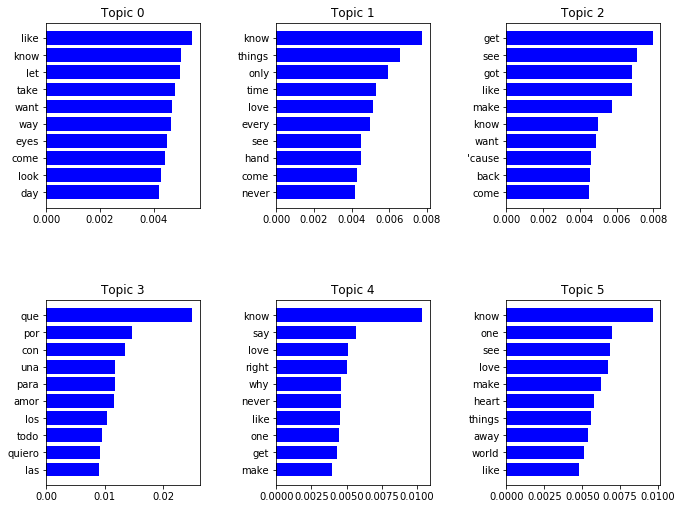

In [349]:
#plotting horizontal bar charts
from matplotlib import gridspec
top_words[0][:6]
top_betas[0][:6]
gs  = gridspec.GridSpec(2,3)
gs.update(wspace=0.5, hspace=0.5)
plt.figure(figsize=(11,8.5))
for i in range(6):
    #new subplot
    ax = plt.subplot(gs[i])
    plt.barh(range(10), top_betas[i][:10], align='center',color='blue', ecolor='black')
    ax.invert_yaxis()
    ax.set_yticks(range(10))
    ax.set_yticklabels(top_words[i][:10])
    plt.title("Topic "+str(i))
_ = plt.show()

### Wordclouds of lyrics data

(-0.5, 399.5, 199.5, -0.5)

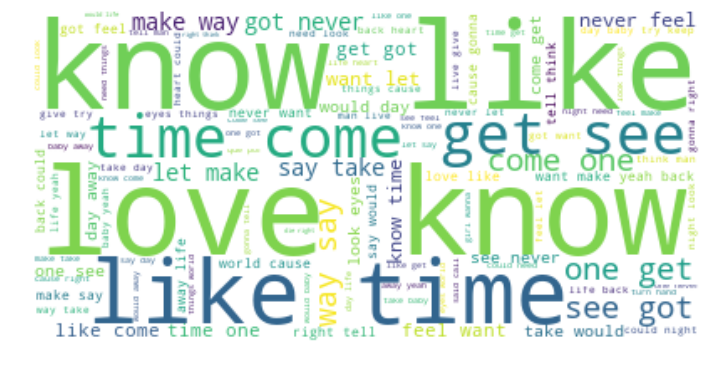

In [350]:
from os import path
from PIL import Image

from wordcloud import WordCloud, STOPWORDS

# Read the whole text.
t = list(lyrics_2_sub['word'])
text_cloud = ' '.join(t)

# read the mask image
# https://banner2.kisspng.com/20180308/eiq/kisspng-musical-note-graphic-design-flying-notes-5aa11bbb905150.6488331115205078355911.jpg
#music_mask = np.array(Image.open(msd_subset_path + '/musixmatch/music.jpg' ))

wc = WordCloud(background_color="white", max_words=100,
               stopwords=stop, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text_cloud)

# store to file
#wc.to_file('./wordclouds/words.png')

# show
plt.figure(figsize=(12, 10))
plt.imshow(wc, interpolation='bilinear');
plt.axis("off")

#plt.imshow(music_mask, cmap=plt.cm.gist_rainbow, interpolation='bilinear');
plt.axis("off")


### plotting wordclouds for each topic

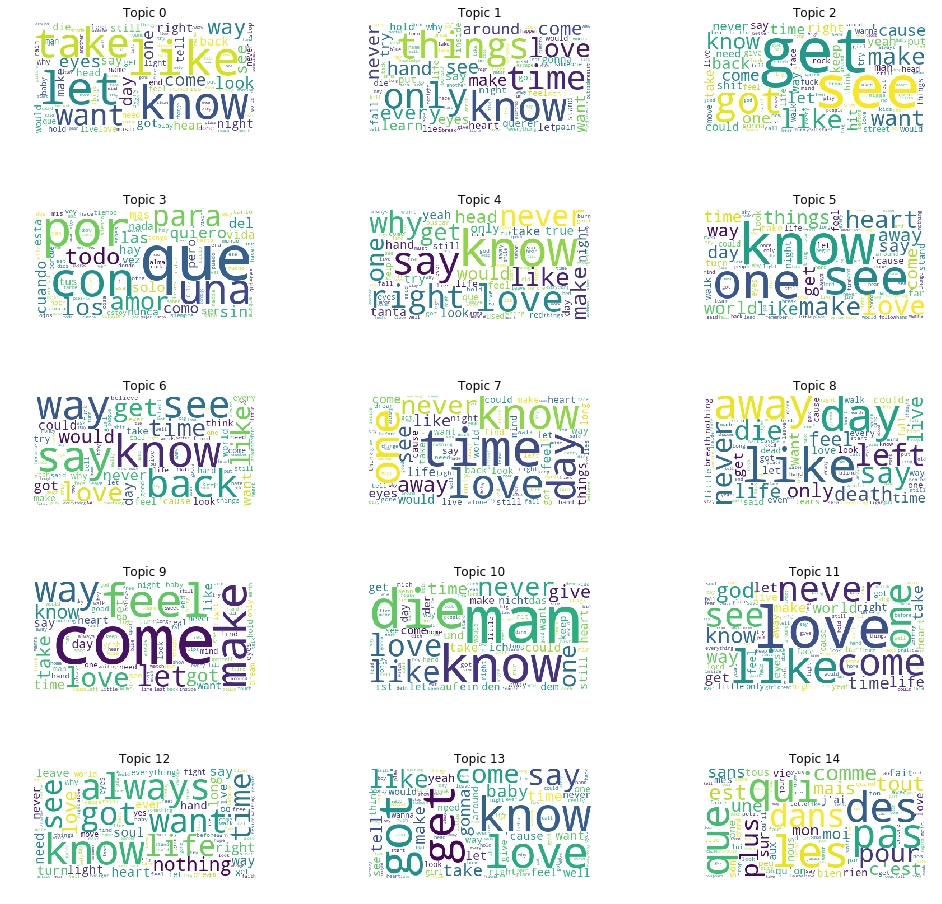

In [358]:
#plotting word cloud for each topic
gs  = gridspec.GridSpec(5,3)
gs.update(wspace=0.5, hspace=0.5)
plt.figure(figsize=(16,16))
for i in range(final_model.num_topics):
    #new subplot
    ax = plt.subplot(gs[i])
    plt.imshow(WordCloud(background_color="white", max_words=100,stopwords=stop, contour_width=3, contour_color='steelblue').fit_words(dict(final_model.show_topic(i, 200))))
    #ax.invert_yaxis()
    ax.axis("off")
    plt.title("Topic "+str(i))
    plt.tight_layout()
_ = plt.show()

### Assigning Topics to Songs

> *Utlizing* ***[Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity)*** *which utilizes the definition of similairy through the relationship between the dot product of 2 vectors and cosine:*
![cosine sim formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d)

In [353]:
#Calculates the cosine similarity between 2 lists of strings
def cosine_sim(a,b):
    from collections import Counter

    # count word occurrences
    a_vals = Counter(a)
    b_vals = Counter(b)

    # convert to word-vectors
    words  = list(a_vals.keys() | b_vals.keys())
    a_vect = [a_vals.get(word, 0) for word in words]        
    b_vect = [b_vals.get(word, 0) for word in words]        

    # find cosine
    len_a  = sum(av*av for av in a_vect) ** 0.5             
    len_b  = sum(bv*bv for bv in b_vect) ** 0.5             
    dot_product = sum(av*bv for av,bv in zip(a_vect, b_vect))    
    cosine_similarity = dot_product / (len_a * len_b)                          
    
    return cosine_similarity

In [354]:
#demo of the function
cosine_sim(['This', 'is', 'a', 'test', 'list', 'with', 'extra', 'words'],['This', 'is', 'a', 'test', 'list'])

0.7905694150420948

In [355]:
score_matrix = []
for name in lyrics.index:
    scores = []
    word_index = np.nonzero(lyrics.loc[name])
    word_list = tuple([lyrics.columns[i] for i in word_index][0])
    for topic in topic_words:
        try:
            score = cosine_sim(list(word_list),topic)
            scores.append(score)
        except:
            pass
    score_matrix.append(scores)
        

df_cos = pd.DataFrame(score_matrix, columns=['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8','Topic 9','Topic 10','Topic 11','Topic 12','Topic 13','Topic 14','Topic 15'], index=lyrics.index)


In [359]:
df_cos.shape

(2349, 15)

In [357]:
df_cos.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
track_id,,,,,,,,,,,,,,,
TRAAABD128F429CF47,0.000000,0.000000,0.000000,0.014907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014907,0.000000,0.000000,0.000000,0.000000
TRAAAEF128F4273421,0.000000,0.017961,0.017961,0.000000,0.017961,0.017961,0.017961,0.017961,0.017961,0.017961,0.017961,0.017961,0.017961,0.017961,0.035921
TRAAAFD128F92F423A,0.000000,0.000000,0.000000,0.014434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014434,0.000000,0.000000,0.028868
TRAAARJ128F9320760,0.013608,0.013608,0.027217,0.027217,0.000000,0.000000,0.013608,0.013608,0.000000,0.027217,0.000000,0.027217,0.013608,0.013608,0.013608
TRAABJV128F1460C49,0.028571,0.028571,0.014286,0.028571,0.000000,0.014286,0.014286,0.014286,0.000000,0.014286,0.028571,0.014286,0.014286,0.014286,0.014286


In [368]:
df_cos1 = df_cos.apply(lambda x: x == x.max(), axis=1).astype(int) 

In [500]:
df_cos1.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
track_id,,,,,,,,,,,,,,,
TRAAABD128F429CF47,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
TRAAAEF128F4273421,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TRAAAFD128F92F423A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
TRAAARJ128F9320760,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
TRAABJV128F1460C49,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0


### Lets use topics information ONLY to predict song hotness

In [508]:
print('Shape of topics data: ' + str(df_cos1.shape))

#getting song hotness only for tracks that are available in topics data

df_lyrics_subset = pd.merge(df_cos1,subset_augmented[['track_id','song_hotttnesss']], on = 'track_id', how = 'inner')


Shape of topics data: (2349, 15)


In [509]:
df_lyrics_subset.head()

,track_id,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,song_hotttnesss
0,TRAAABD128F429CF47,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,NaN
1,TRAAAEF128F4273421,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN
2,TRAAAFD128F92F423A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.604501
3,TRAAARJ128F9320760,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0.265861
4,TRAABJV128F1460C49,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,NaN


In [510]:
#dropping rows with missing song hotness
data = df_lyrics_subset.dropna(subset = ['song_hotttnesss'])
print('Shape of dataframe after removing missing song hotness: ' + str(data.shape))


#selecting numeric columns
data_num = data._get_numeric_data()
print('Shape of dataframe after selecting numeric columns: ' + str(data_num.shape))


#assigning song hotness to a target while dropping it from featureset
song_hotness = data_num[['song_hotttnesss']]
data_num = data_num.drop(columns = 'song_hotttnesss')                                     


featureset = data_num

print('Shape of featureset: ' + str(featureset.shape) + ' and shape of target: '+ str(song_hotness.shape))


Shape of dataframe after removing missing song hotness: (1667, 17)
Shape of dataframe after selecting numeric columns: (1667, 16)
Shape of featureset: (1667, 15) and shape of target: (1667, 1)


In [511]:
featureset.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
6,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0
7,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0


In [512]:
#Assigning top 25% songs with respect to song hotness as a hot song
song_hotness['song_hotttnesss'] = song_hotness['song_hotttnesss']>=0.537504


In [513]:
song_hotness.song_hotttnesss.value_counts()

False    906
True     761
Name: song_hotttnesss, dtype: int64

As seen above, total 761 songs are classified as hot songs in lyrics data

### Classical models

In [514]:
#lets replace all NAs in feature set with 0 
featureset.fillna(0, inplace= True)

In [515]:
#split data into train and test

ratio = 0.7

nrow = np.random.rand(len(featureset)) <= 0.7

X_train = featureset[nrow]
X_test = featureset[~nrow]
y_train = song_hotness[nrow].values.ravel()
y_test = song_hotness[~nrow].values.ravel()

In [516]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

### Fitting various classical models and plotting their accuracy metrics

Accuracy and AUC (test) for Logistic: 50.7% and 0.48 respectively 
Accuracy and AUC (test) for Naive Bayes: 51.1% and 0.50 respectively 
Accuracy and AUC (test) for Support Vector Classification: 50.9% and 0.48 respectively 
Accuracy and AUC (test) for Random Forest: 48.1% and 0.47 respectively 


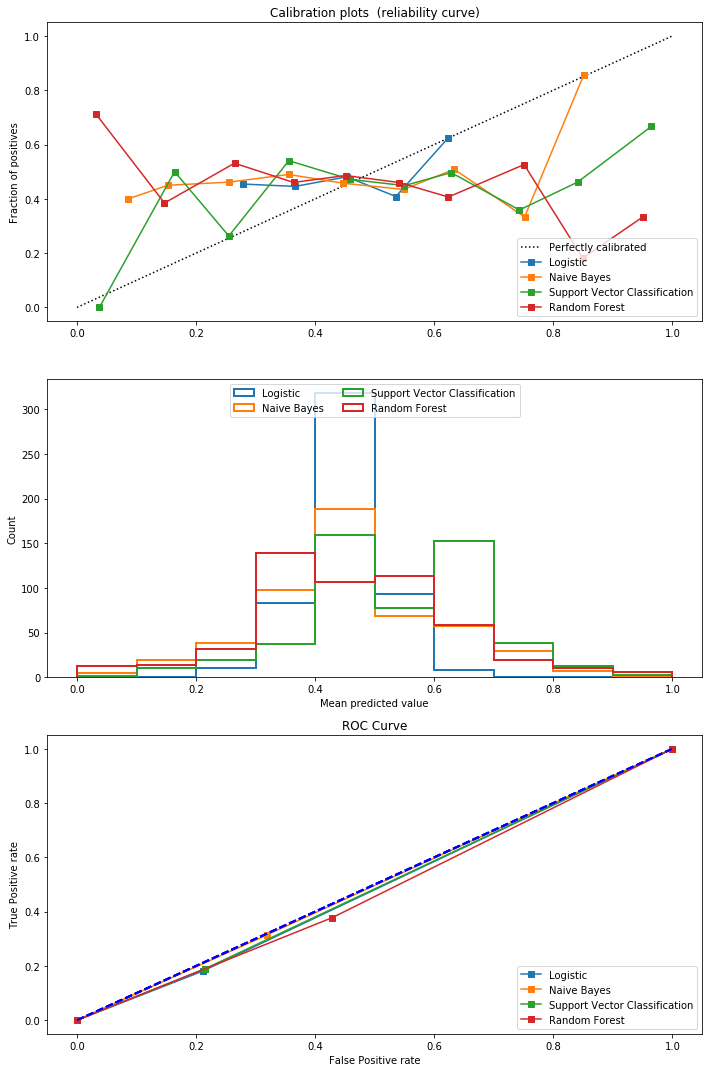

In [517]:
import warnings
warnings.filterwarnings('ignore')
# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,figsize=(10, 15))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
        
    # computing accuracy    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    #computing auc
    auc = roc_auc_score(y_pred,y_test)
    print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))
    
    #computing fpr and tpr
    fpr, tpr,_= roc_curve(y_test,y_pred,drop_intermediate=False)
       

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
    
    ax3.plot(fpr, tpr, "s-", label="%s" % (name, ))
    ax3.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


ax3.set_xlabel("False Positive rate")
ax3.set_ylabel("True Positive rate")
ax3.set_ylim([-0.05, 1.05])
ax3.legend(loc="lower right")
ax3.set_title('ROC Curve')

plt.tight_layout()
plt.show()


    

### As shown above, topics on their own dont have much impact on song hotness. Lets see if topics information in addition to other information about songs lead to better accuracy

### Lets use all information from augmented subset and topics information from lyrics data to predict song hotness

In [585]:
from sklearn.preprocessing import MinMaxScaler


print('Total columns in augmented data: ' + str(subset_augmented.shape[1]))

#merging topics with augmented data

df_lyrics_subset = pd.merge(df_cos1,subset_augmented, on = 'track_id', how = 'inner')
print('Shape of dataframe after adding topics: ' + str(df_lyrics_subset.shape))


#dropping rows with missing song hotness
data = df_lyrics_subset.dropna(subset = ['song_hotttnesss'])
print('Shape of dataframe after removing missing song hotness: ' + str(data.shape))


#selecting numeric columns
data_num = data._get_numeric_data()
print('Shape of dataframe after selecting numeric columns: ' + str(data_num.shape))


#dropping danceability and energy and digital id 
cols_to_drop = ['danceability', 'energy', 'release_7digitalid', 'track_7digitalid','artist_7digitalid','artist_playmeid']
data_num = data_num.drop(columns = cols_to_drop)
print('Shape of dataframe after deleting ids and other useless numeric columns: ' + str(data_num.shape))

#assigning song hotness to a target while dropping it from featureset
song_hotness = data_num[['song_hotttnesss']]
data_num = data_num.drop(columns = 'song_hotttnesss')                               
          
                
#scaling numeric columns
scaler = MinMaxScaler() 
data_num_scaled = pd.DataFrame(scaler.fit_transform(data_num.values),columns = data_num.columns)


#adding useful string columns genre and style and add one hot encoded features for the same

cols_to_encode = ['genre_id', 'style_id']
string_encoded_features = pd.get_dummies(data[cols_to_encode], prefix=['genre', 'style']).reset_index(drop = True)
featureset = pd.concat([data_num_scaled, string_encoded_features],axis = 1)


print('Shape of dataframe after adding encoded features for string columns: ' + str(featureset.shape))

print('Shape of featureset: ' + str(featureset.shape) + ' and shape of target: '+ str(song_hotness.shape))


Total columns in augmented data: 116
Shape of dataframe after adding topics: (2349, 131)
Shape of dataframe after removing missing song hotness: (1667, 131)
Shape of dataframe after selecting numeric columns: (1667, 99)
Shape of dataframe after deleting ids and other useless numeric columns: (1667, 93)
Shape of dataframe after adding encoded features for string columns: (1667, 132)
Shape of featureset: (1667, 132) and shape of target: (1667, 1)


In [586]:
#lets replace all NAs in feature set with 0 
featureset.fillna(0, inplace= True)

In [587]:
#Assigning top 25% songs with respect to song hotness as a hot song
song_hotness['song_hotttnesss'] = song_hotness['song_hotttnesss']>=0.537504


In [588]:
song_hotness.song_hotttnesss.value_counts()

False    906
True     761
Name: song_hotttnesss, dtype: int64

In [589]:
#split data into train and test

ratio = 0.7

nrow = np.random.rand(len(featureset)) <= 0.7

X_train = featureset[nrow]
X_test = featureset[~nrow]
y_train = song_hotness[nrow].values.ravel()
y_test = song_hotness[~nrow].values.ravel()

### Fitting various classical models and plotting their accuracy metrics

Accuracy and AUC (test) for Logistic: 72.0% and 0.72 respectively 
Accuracy and AUC (test) for Naive Bayes: 50.9% and 0.68 respectively 
Accuracy and AUC (test) for Support Vector Classification: 71.2% and 0.71 respectively 
Accuracy and AUC (test) for Random Forest: 70.2% and 0.70 respectively 


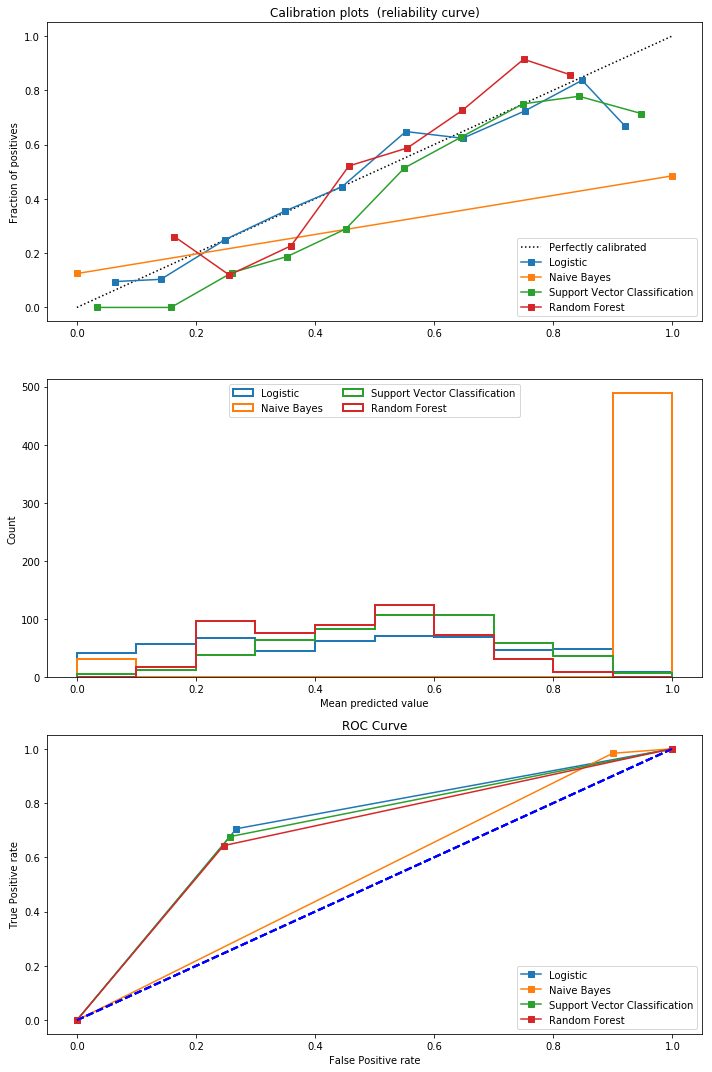

In [590]:
import warnings
warnings.filterwarnings('ignore')
# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,figsize=(10, 15))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)
        
    # computing accuracy    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    #computing auc
    auc = roc_auc_score(y_pred,y_test)
    print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))
    
    #computing fpr and tpr
    fpr, tpr,_= roc_curve(y_test,y_pred,drop_intermediate=False)
       

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))
    

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)
    
    
    ax3.plot(fpr, tpr, "s-", label="%s" % (name, ))
    ax3.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


ax3.set_xlabel("False Positive rate")
ax3.set_ylabel("True Positive rate")
ax3.set_ylim([-0.05, 1.05])
ax3.legend(loc="lower right")
ax3.set_title('ROC Curve')

plt.tight_layout()
plt.show()


    

In [591]:
#lets fit a random forest model and then find features that are important to predict song hotness

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

# computing accuracy    
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

#computing auc
auc = roc_auc_score(y_pred,y_test)
print("Accuracy and AUC (test) for %s: %0.1f%% and %0.2f respectively " % (name, accuracy * 100, auc))


Accuracy and AUC (test) for Random Forest: 70.2% and 0.70 respectively 


Text(0.5, 0, 'Relative Importance')

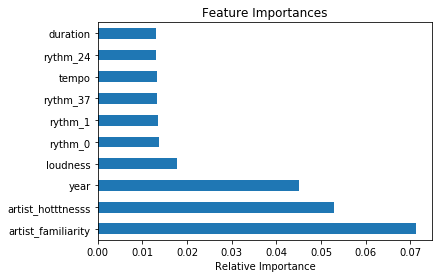

In [592]:
feat_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')

### The accuracy based on lyrics subset data actually got lower primarily because that lyrics is not available for songs related to Pop-Rock genre, which happen to be a signifiant feature for song hotness

## Findings:

- Artist familiarity and hotness, along with song loudness, tempo and few rythm variables seem to be a good predictor of song hotness
- Classical models as well as MLP did equally well to predict song hotness. Random Forest perfored the best with close to 80% accuracy and auc = 0.8.
- Lyrics were analysed for the songs from the subset for which it was available
- Applied LDA to categorise lyrics into 15 topics. Word clouds for these topics found that words like 'Love', 'Heart', 'Like', 'Time' were important words.
- The topics generated in this way was used to predict song hotness. We noticed that topics do not have an impact on song hotness.

# Investigate numerical arrays

Several of the columns include lists of numbers, which are explored further in this section. 

The dataset contains numerical information in the form of arrays for distinct parts of each song:

1. __Bars__:  A bar (or measure) is a segment of time defined as a given number of beats. 

2. __Beats__:  A beat is the basic time unit of a piece of music; for example, each tick of a metronome. Beats are typically multiples of tatums.

3. __Sections__: Sections are defined by large variations in rhythm or timbre, e.g. chorus, verse, bridge, guitar solo, etc.

4. __Segments__: A set of sound entities (typically under a second) each relatively uniform in timbre and harmony. 

5. __Tatums__: Tatums represent the lowest regular pulse train that a listener intuitively infers from the timing of perceived musical events (segments). 

All of these parts have two columns associated with them:

* __Start:__ the markers explained above, in seconds.

* __Confidence:__ Confidence indicates the reliability of its corresponding attribute. Elements carrying a small confidence value should be considered speculative. 

The most detailed information is for segments, which contain several other features:
* __Loudness_max__: peak loudness value within the segment
* __Loudness_max_time__: offset within the segment of the point of maximum loudness 
* __Loudness_start__: loudness level at the start of the segment 
* __Pitches__:  is given by a “chroma” vector, corresponding to the 12 pitch classes C, C#, D to B, with values ranging from 0 to 1 that describe the relative dominance of every pitch in the chromatic scale.
* __Timbre__: is the quality ('colour') of a musical note. It is what makes a particular musical sound different from another, even when they have the same pitch and loudness. The dataset represents timbre as a 12 dimensional vector of 'MFCC-like' features, each of which are unbounded values roughly centered around 0. 

The number of segments per track is variable and each segment can itself be of variable length - typically they seem to be around 0.2 - 0.4 seconds but can be as long as 10 seconds or more.

In [106]:
# Identify the columns that have arrays
numerical_array_list = ['bars_confidence',
                       'bars_start',
                       'beats_confidence',
                       'beats_start',
                        'sections_confidence',
                        'sections_start',
                        'segments_confidence',
                        'segments_loudness_max',
                        'segments_loudness_max_time',
                        'segments_loudness_start',
                        'segments_pitches',
                        'segments_start',
                        'segments_timbre',
                        'tatums_confidence',
                        'tatums_start'
                       ]

# Create lookups
lookups = dict(enumerate(numerical_array_list))

# Get the lengths of each array
array_lengths = []
for column in numerical_array_list:
    length = [len(i) for i in subset_full[column]]
    array_lengths.append(length) 


It is already clear from the descriptions, and verified by looking at the shapes of the arrays for the first few tracks below, that they will be of different lengths. This is because the length of tracks and frequency of the audio features varies greatly.  

Below, we can see that the histogram of the length of the arrays for the different events is highly skewed. 

In [83]:
# Let's look at the shape of the arrays for the first songs
print('Array shapes for the first song')
for i, column in enumerate(numerical_array_list):
    print(i, subset_full[column][0].shape) 

print('Array shapes for the second song')
for i, column in enumerate(numerical_array_list):
    print(i, subset_full[column][1].shape) 

Array shapes for the first song
0 (73,)
1 (73,)
2 (294,)
3 (294,)
4 (6,)
5 (6,)
6 (562,)
7 (562,)
8 (562,)
9 (562,)
10 (562, 12)
11 (562,)
12 (562, 12)
13 (587,)
14 (587,)
Array shapes for the second song
0 (69,)
1 (69,)
2 (333,)
3 (333,)
4 (9,)
5 (9,)
6 (774,)
7 (774,)
8 (774,)
9 (774,)
10 (774, 12)
11 (774,)
12 (774, 12)
13 (997,)
14 (997,)


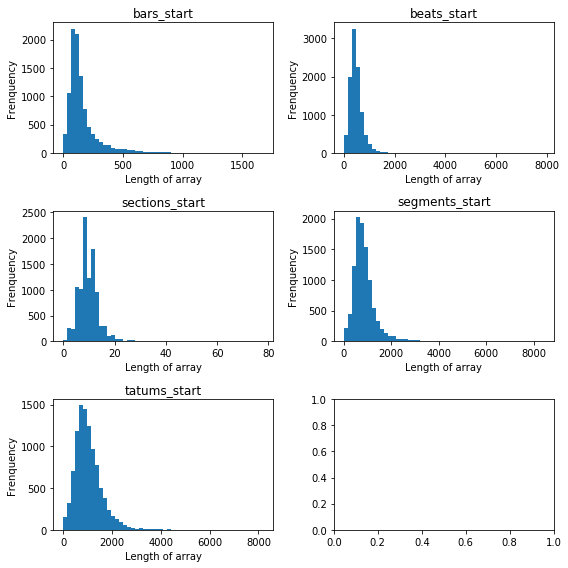

In [191]:
# Select the "start" variable of each type
start_list = [1, 3, 5, 11, 14]

fig, axes = plt.subplots(3, 2, figsize = (8, 8))
ax = axes.ravel()
for i, k in enumerate(start_list):
    ax[i].hist(array_lengths[k], bins = 50)
    ax[i].set_title(lookups[k])
    ax[i].set_xlabel('Length of array')
    ax[i].set_ylabel('Frenquency')
plt.tight_layout()

The segment pitches and timbre information comes in 12 vectors. 

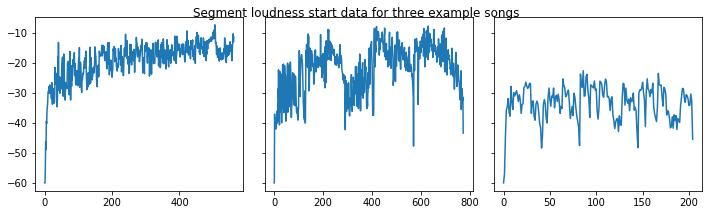

In [197]:

fig, axes = plt.subplots(1, 3, figsize = (10, 3), sharey = True)
ax = axes.ravel()
for i in range(3):
    ax[i].plot(subset_full['segments_loudness_start'][i])
plt.suptitle('Segment loudness start data for three example songs')
plt.tight_layout()

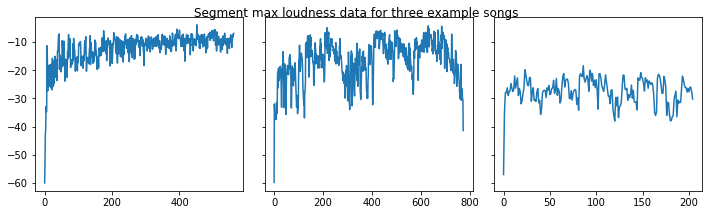

In [198]:
fig, axes = plt.subplots(1, 3, figsize = (10, 3), sharey = True)
ax = axes.ravel()
for i in range(3):
    ax[i].plot(subset_full['segments_loudness_max'][i])
plt.suptitle('Segment max loudness data for three example songs')
plt.tight_layout()

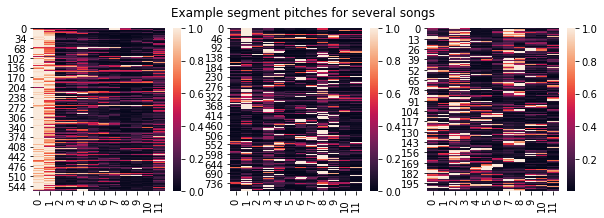

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))
sns.heatmap(subset_full['segments_pitches'][0], ax = ax1)
sns.heatmap(subset_full['segments_pitches'][1], ax = ax2)
sns.heatmap(subset_full['segments_pitches'][2], ax = ax3)
plt.suptitle('Segment pitches for three example songs');



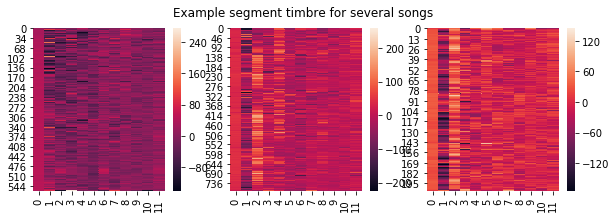

In [158]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3))
sns.heatmap(subset_full['segments_timbre'][0], ax = ax1)
sns.heatmap(subset_full['segments_timbre'][1], ax = ax2)
sns.heatmap(subset_full['segments_timbre'][2], ax = ax3)
plt.suptitle('Segment timbre for three example songs');